<font size="6"> <div style="text-align: center"> **Time Series Regression on Cloud Analytics Case Study**

# Introduction

A consultant's firm client wants to mitigate its costs on AWS platform and, so, we are in charge of finding a solution for this issue based on 2 solutions:
1.	Forecasting Cloud Spend for the Next Quarter: The client wants to develop a forecast for their cloud spend to build their budget for the upcoming quarter. This involves using the cost and billing usage report from the past 18 months to predict the expected cloud spend for the next quarter accurately.
2.	Identifying Spend Areas for Optimization Efforts: The client wants to understand which specific AWS services are driving growth in their spend so that they can prioritize optimization efforts. He also wants to know if the efforts on Product and/or on Service should be prioritized and which ones.

We'll decompose the answer of the 2 problems into 4 parts:



*   Data Exploration and Analysis
*   Feature Engineering
*   Forecasting models using ML and DL to answer question 1
*   Cluster Analysis to answer question 2






In [6]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import datetime as dt
import itertools
import random
import re
import math

from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from plotnine import *
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")

## Data Upload

In [7]:
# import and see nb rows and columns of the input dataset
df_raw = pd.read_csv('/content/drive/MyDrive/cost_data.csv',  sep='|')
df_raw.shape

(1719914, 11)

## Exploratory Data Analysis

### Global Analysis

In [8]:
# To verify uniqueness of records
df_raw.duplicated().sum()

0

In [9]:
# verify columns and their dtypes
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719914 entries, 0 to 1719913
Data columns (total 11 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   usage_date             object 
 1   line item type         object 
 2   product code           object 
 3   line item description  object 
 4   usage type             object 
 5   usage type (aws)       object 
 6   operation              object 
 7   environment (tag)      object 
 8   product (tag)          object 
 9   amortized_cost         float64
 10  usage_amount           float64
dtypes: float64(2), object(9)
memory usage: 144.3+ MB


In [10]:
# remove spaces and paranthesis in columns name
df_raw.columns = df_raw.columns.str.replace(' ','_').str.replace('[()]', '')
df_raw.columns

Index(['usage_date', 'line_item_type', 'product_code', 'line_item_description',
       'usage_type', 'usage_type_aws', 'operation', 'environment_tag',
       'product_tag', 'amortized_cost', 'usage_amount'],
      dtype='object')

In [11]:
# brief look at the raw dataset
df_raw.head(5)

,usage_date,line_item_type,product_code,line_item_description,usage_type,usage_type_aws,operation,environment_tag,product_tag,amortized_cost,usage_amount
0,2021-10-10,Usage,AmazonEC2,$0.010 per GB - regional data transfer - in/ou...,Data Volume,DataTransfer-Regional-Bytes,InterZone-Out,NaN,Product 5,2.459866,245.986809
1,2021-10-11,Usage,AmazonCloudWatch,$0.03 per GB-mo of log storage - US East (Nort...,Storage,USE1-TimedStorage-ByteHrs,HourlyStorageMetering,NaN,Product 5,1.513749,50.458333
2,2021-10-12,Usage,AmazonS3,"$0.004 per 10,000 GET and all other requests",Operations,Requests-Tier2,ReadRequestPaymentProps,NaN,Product 5,0.000248,620.000000
3,2021-10-25,Usage,AWSELB,$0.008 per used Application load balancer capa...,Capacity Hour,LCUUsage,LoadBalancing:Application,NaN,Product 5,0.187315,23.414373
4,2021-10-02,Usage,AmazonS3,"$0.004 per 10,000 GET and all other requests",Operations,Requests-Tier2,WebsiteHeadObject,NaN,Product 5,0.000000,1.000000


In [12]:
# transform usage_date to datetime

df_raw['usage_date'] = pd.to_datetime(df_raw['usage_date'])
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719914 entries, 0 to 1719913
Data columns (total 11 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   usage_date             datetime64[ns]
 1   line_item_type         object        
 2   product_code           object        
 3   line_item_description  object        
 4   usage_type             object        
 5   usage_type_aws         object        
 6   operation              object        
 7   environment_tag        object        
 8   product_tag            object        
 9   amortized_cost         float64       
 10  usage_amount           float64       
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 144.3+ MB


In [13]:
# describe and see summary statistics for all the variables of our dataset

def summary(df):
  desc = df.describe(include = 'all').T.rename(columns={"count": "count_non_nulls"})
  desc['count_nulls'] = df.shape[0]-desc['count_non_nulls']
  new_index_list = ['count_non_nulls', 'count_nulls']
  new_index=new_index_list + [c for c in desc.columns if c not in new_index_list]
  desc = desc.reindex(new_index, axis='columns')

  return desc

desc_ini = summary(df_raw)
desc_ini

,count_non_nulls,count_nulls,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
usage_date,1719914,0,547,2023-01-25 00:00:00,4586,2021-10-01,2023-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
line_item_type,1719914,0,5,Usage,1687533,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_code,1719914,0,61,AmazonS3,632070,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
line_item_description,1719914,0,1334,$0.090 per GB - first 10 TB / month data trans...,166415,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage_type,1682612,37302,27,Data Volume,911946,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage_type_aws,1719914,0,1467,Requests-Tier2,80953,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
operation,1719770,144,359,RunInstances,192366,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environment_tag,778281,941633,15,prod,392118,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_tag,1718762,1152,8,Product 5,846370,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amortized_cost,1719901.0,13.0,NaN,NaN,NaN,NaT,NaT,1.378166,16.747565,-3.685345,0.0,0.000002,0.000626,5198.294385


So far, we can see that this dataset is relatively large with low dimensionality in terms of columns. We have a date column ('usage_date'), which will be key to perform the time series forecasting, 2 measure float continuous variables ('usage_amount' and 'amortized_cost') and 8 remaining categorical variables (some related with AWS service and the others related client’s infrastructure components).
**The variable 'amortized_cost' which is what we want to predict in the forecast - dependent variable of our models.**

We see some coluns with null values as well and we have to decide later what to do with those missing values. Some categorical values have a lot of cardinality as well (or distinct values), which is not a good indicator for creating any model. However, there are some dominant values and there can be a lot of insignificant categories in each variable.
As far as the continuous variables we can see, is that there are negative values, which don't make sense and will be removed (unless is some kind of correction) and the percentile 25 is 0 in both cases, indicating, right away, **that we have a lot of free costs usage and a lot of operations with an insignicficant amount of usage**.

Below, let's try to find relationships between variables and do exploratory analysis on what can be cleaned as well or redo, in order to reduce some volumetry for the database (which will easy the modelling part) as well to do some treatments on the categorical fields - feature engineering.

###Variable Analysis / Feature Engineering

#### Date Variable - *Usage Date*

This is the date variable that is key to model the forecasting with a certain lag the future 6 months of costs. This is has a daily distribution and goes from 2021-10-01 to 2023-03-31.

In [14]:
# let's check if we have all days

date_gb = df_raw.groupby('usage_date', dropna=False)\
.agg({'amortized_cost':'count'}).reset_index()

date_gb['date_gap'] = date_gb['usage_date'].diff()
date_gb

,usage_date,amortized_cost,date_gap
0,2021-10-01,1906,NaT
1,2021-10-02,1764,1 days
2,2021-10-03,1714,1 days
3,2021-10-04,1908,1 days
4,2021-10-05,1943,1 days
...,...,...,...
542,2023-03-27,4398,1 days
543,2023-03-28,4416,1 days
544,2023-03-29,4438,1 days
545,2023-03-30,4369,1 days


In [15]:
date_gb.date_gap.value_counts()

1 days    546
Name: date_gap, dtype: int64

Indeed we have all consecutive days from first to last date!

It might be relevant to include variables like the weekday, the month, or even the quarter, to see if there is some **seasonality** in terms of higher or lower costs. For the year, it doesnt make sense to check because we have less months for 2021 and 2023 compared to the full 2022.

In [16]:
df_initial = df_raw.copy()
df_initial['month'] = pd.DatetimeIndex(df_initial['usage_date']).month
df_initial['quarter'] = pd.DatetimeIndex(df_initial['usage_date']).quarter
df_initial['weekday'] = pd.DatetimeIndex(df_initial['usage_date']).weekday # 0 monday to 6 sunday
df_initial

,usage_date,line_item_type,product_code,line_item_description,usage_type,usage_type_aws,operation,environment_tag,product_tag,amortized_cost,usage_amount,month,quarter,weekday
0,2021-10-10,Usage,AmazonEC2,$0.010 per GB - regional data transfer - in/ou...,Data Volume,DataTransfer-Regional-Bytes,InterZone-Out,NaN,Product 5,2.459866,245.986809,10,4,6
1,2021-10-11,Usage,AmazonCloudWatch,$0.03 per GB-mo of log storage - US East (Nort...,Storage,USE1-TimedStorage-ByteHrs,HourlyStorageMetering,NaN,Product 5,1.513749,50.458333,10,4,0
2,2021-10-12,Usage,AmazonS3,"$0.004 per 10,000 GET and all other requests",Operations,Requests-Tier2,ReadRequestPaymentProps,NaN,Product 5,0.000248,620.000000,10,4,1
3,2021-10-25,Usage,AWSELB,$0.008 per used Application load balancer capa...,Capacity Hour,LCUUsage,LoadBalancing:Application,NaN,Product 5,0.187315,23.414373,10,4,0
4,2021-10-02,Usage,AmazonS3,"$0.004 per 10,000 GET and all other requests",Operations,Requests-Tier2,WebsiteHeadObject,NaN,Product 5,0.000000,1.000000,10,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719909,2023-03-05,Usage,AmazonS3,"$0.004 per 10,000 GET and all other requests",Operations,EU-Requests-Tier2,ReadBucketCors,prod,Product 6,0.000019,48.000000,3,1,6
1719910,2023-03-20,Usage,AmazonEC2,$0.00 per GB - US West (Northern California) d...,Data Volume,USW1-EUW3-AWS-In-Bytes,PublicIP-In,qa,Product 6,0.000000,0.000000,3,1,0
1719911,2023-03-15,Usage,AmazonS3,$0.02 per GB - EU (Ireland) data transfer to U...,Data Volume,EU-USE1-AWS-Out-Bytes,ReadBucketPublicAccessBlock,prod,Product 6,0.000000,0.000003,3,1,2
1719912,2023-03-29,Usage,AWSLambda,$0.00 per GB - Asia Pacific (Singapore) data t...,Data Volume,APS1-USE1-AWS-In-Bytes,Invoke,NaN,Product 5,0.000000,0.001884,3,1,2


**Let's check now the distribution of days with the dependent variable, the amortized cost.**

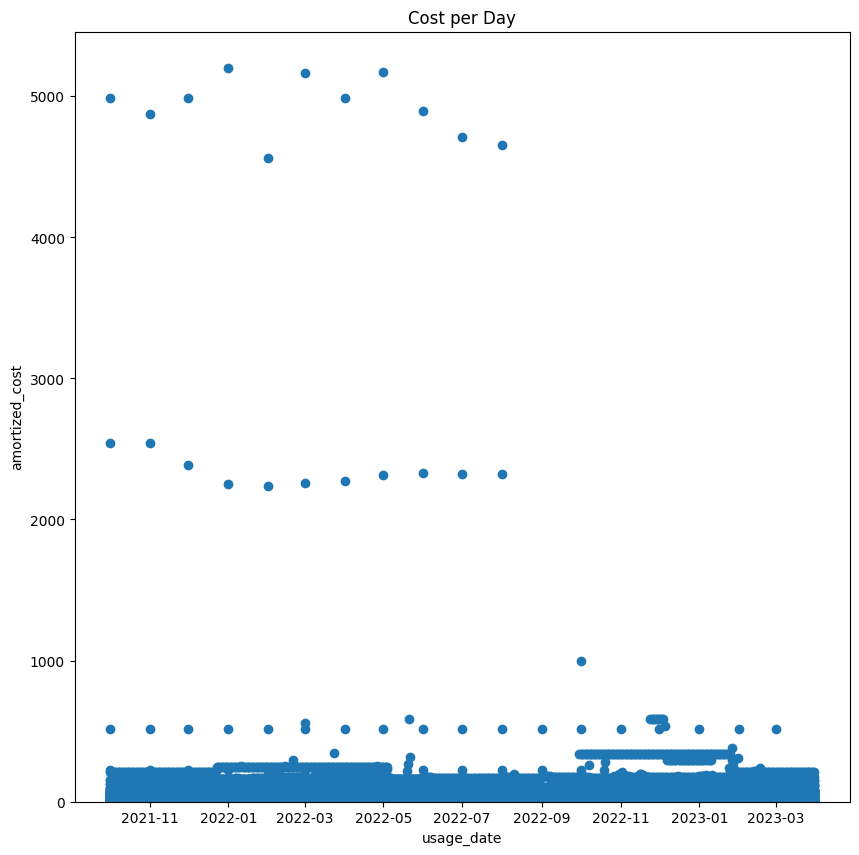

In [19]:
# plot the relationship between both variables
def scatterplot(df, x, y, title, figsize = (10,10), ylim = (0,None)):
  plt.figure(figsize=figsize)
  plt.scatter(df[x], df[y])
  plt.xlabel(x)
  plt.ylabel(y)
  plt.ylim(ylim)
  plt.title(title)

  return plt.show()

scatterplot(df_initial, 'usage_date', 'amortized_cost', "Cost per Day")

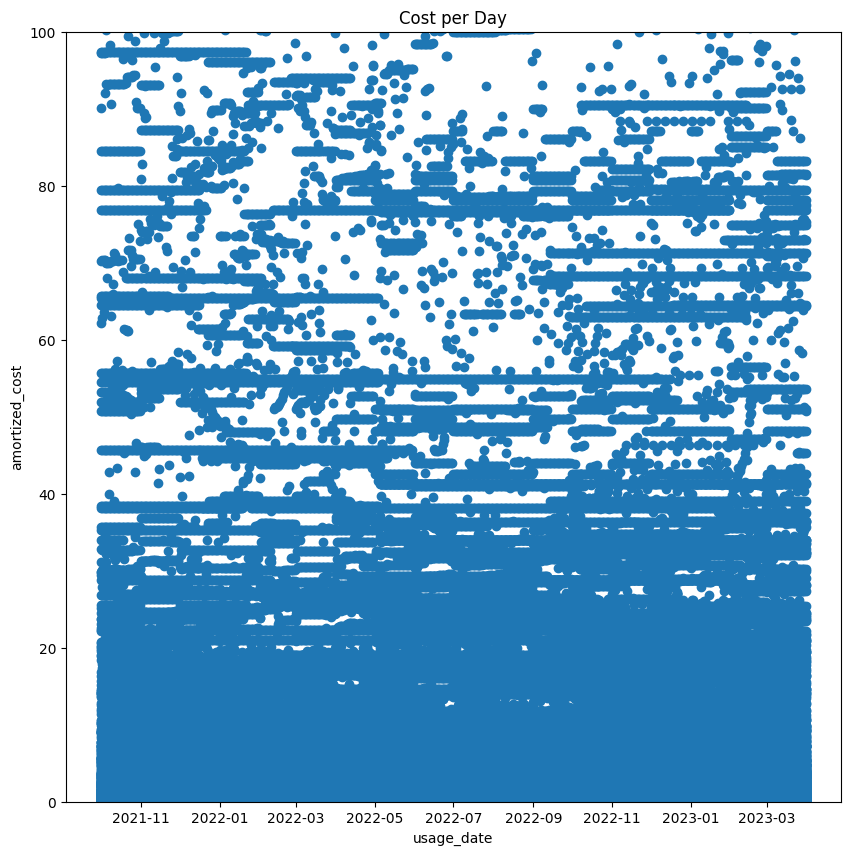

In [20]:
# now zoomed in

scatterplot(df_initial, 'usage_date', 'amortized_cost', "Cost per Day", ylim = (0,100))

Right now, its difficult to reach any conclusion, as expected, because we have many data points. What we can see already are outliers.
**Let's check the same but for the other new date columns (filtering for 2022 only so that we avoid bias with incomplete 2021 and 2023 years).**

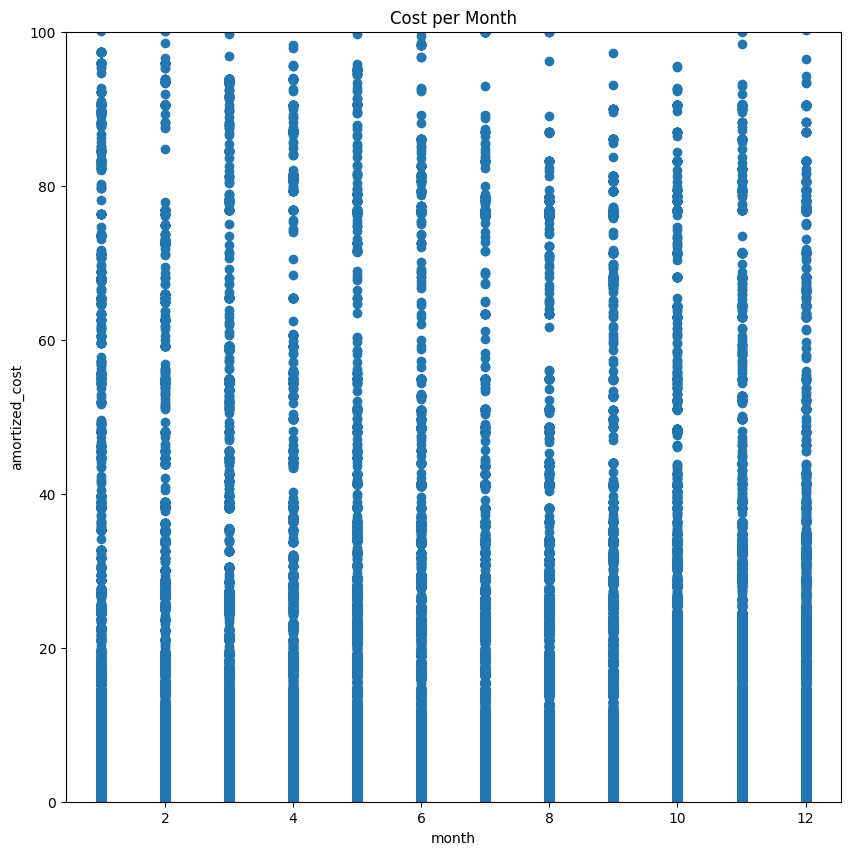

In [21]:
#zoomed in as well from now on to capture the least amount of outliers

df_2022 = df_initial[pd.DatetimeIndex(df_initial['usage_date']).year == 2022]


scatterplot(df_2022, 'month', 'amortized_cost', "Cost per Month", ylim = (0,100))

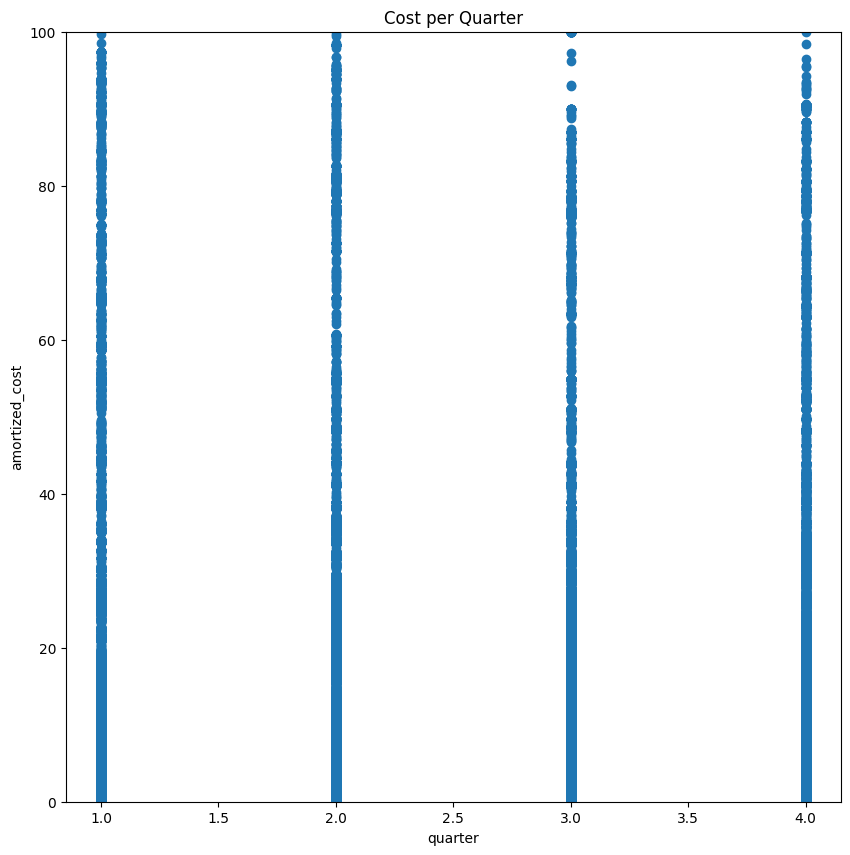

In [22]:
scatterplot(df_2022, 'quarter', 'amortized_cost', "Cost per Quarter", ylim = (0,100))

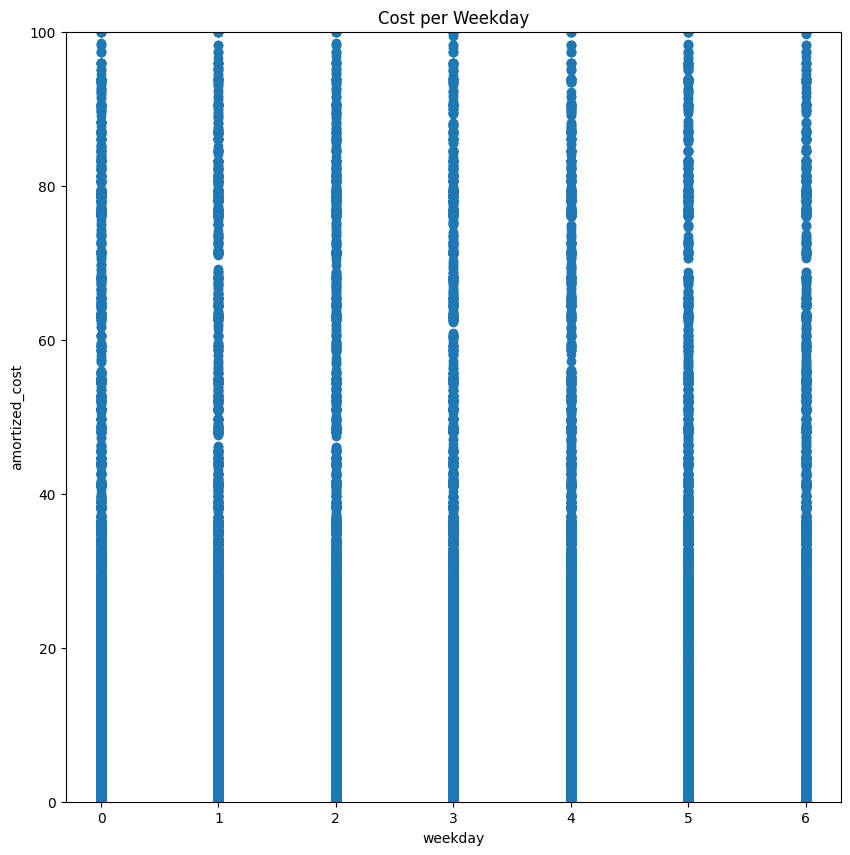

In [23]:
scatterplot(df_2022, 'weekday', 'amortized_cost', "Cost per Weekday", ylim = (0,100))

So, with all these graphs, it's noticeable that:


*   There seems to have more concentration of costs in the beggining of the year than in the middle of the year (Q1 vs Q3).
*   As expected, July and August seem to be the months where there are less costs (due to reduced working load between working people and resources usage, as its presumable).
*   Regarding the week day, it seems more or less uniform between them.





#### Dependent Variable - Amortized Cost

This is the variable we want to predict based on several other independent variables, like the Product Tag and many others, as we will see.

<Axes: xlabel='amortized_cost'>

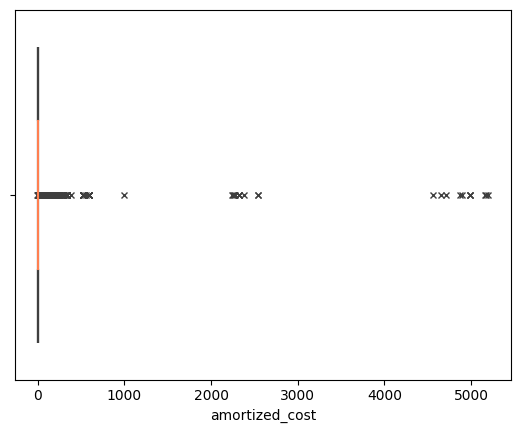

In [24]:
sns.boxplot(
    data=df_initial, x="amortized_cost",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)

The median is very close to 0 as seen here in the boxplot above (we can't even see a box given the huge dispersion of outliers).
So, now, let's remove some outliers based on the 99 percentile.

In [25]:
df2 = df_initial[df_initial.amortized_cost < df_initial.amortized_cost.quantile(.99)]

summary(df2)

,count_non_nulls,count_nulls,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
usage_date,1702537,0,547,2023-01-25 00:00:00,4547,2021-10-01,2023-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
line_item_type,1702537,0,5,Usage,1675297,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_code,1702537,0,61,AmazonS3,630956,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
line_item_description,1702537,0,1322,$0.090 per GB - first 10 TB / month data trans...,166413,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage_type,1665243,37294,27,Data Volume,911246,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage_type_aws,1702537,0,1463,Requests-Tier2,80953,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
operation,1702456,81,358,RunInstances,188547,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environment_tag,769662,932875,15,prod,385080,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_tag,1701422,1115,8,Product 5,838204,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amortized_cost,1702537.0,0.0,NaN,NaN,NaN,NaT,NaT,0.584734,2.873862,-3.685345,0.0,0.000002,0.00044,33.965591


Even though we removed only 17377 rows, we see that the maximum value now for the dependent variable (trimmed to the 99% observation) is only about 34, which is a very different level of magnitude compared to other values.

#### *Usage Amount*

This can be potentially one of the many independent variables and it's the only other float continuous type. It's interesting to check for outliers in this variables as well and **the relationship it has with the amortized_cost.**

<Axes: xlabel='usage_amount'>

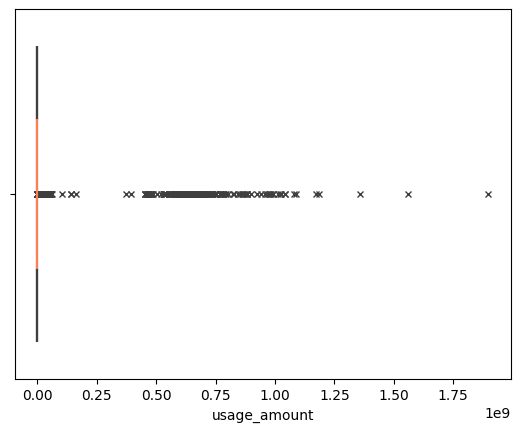

In [26]:
sns.boxplot(
    data=df_initial, x="usage_amount",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)

The same kind of conclusions apply here, where we have some extreme values that bias the distribution of values visually, so, **let's remove the 1% higher percentile as well.**

In [27]:
df3 = df2[df2.usage_amount < df2.usage_amount.quantile(.99)]
summary(df3)

,count_non_nulls,count_nulls,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
usage_date,1685462,0,547,2023-01-25 00:00:00,4501,2021-10-01,2023-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
line_item_type,1685462,0,4,Usage,1658272,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_code,1685462,0,60,AmazonS3,628054,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
line_item_description,1685462,0,1307,$0.090 per GB - first 10 TB / month data trans...,166413,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage_type,1649424,36038,27,Data Volume,911246,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage_type_aws,1685462,0,1450,Requests-Tier2,80305,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
operation,1685431,31,357,RunInstances,188547,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environment_tag,764425,921037,15,prod,381159,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_tag,1684397,1065,8,Product 5,826447,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amortized_cost,1685462.0,0.0,NaN,NaN,NaN,NaT,NaT,0.566467,2.848696,-3.685345,0.0,0.000002,0.00034,33.965591


Still, we see that maximum values can be considered outliers when compared to the 75 percentile (same applies to the cost variable), however, let's keep them because they can be useful for the models.

Now, it's time to remove some more rows based on the lack of coeherency between these 2 variables. In my opinion, **having negative costs or usage amount don't make any sense, and, observations with 0 usage and 0 costs are not relevant for our objective, so, they will be deleted.**

In [28]:
df4 = df3[~((df3['amortized_cost'] <= 0) & (df3['usage_amount'] <= 0) | (df3['amortized_cost'] < 0) | (df3['usage_amount'] < 0))]
summary(df4)

,count_non_nulls,count_nulls,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
usage_date,1594339,0,547,2023-01-25 00:00:00,4386,2021-10-01,2023-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
line_item_type,1594339,0,4,Usage,1567161,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_code,1594339,0,58,AmazonS3,615221,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
line_item_description,1594339,0,1245,$0.090 per GB - first 10 TB / month data trans...,158174,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage_type,1562323,32016,27,Data Volume,826817,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage_type_aws,1594339,0,1380,Requests-Tier2,80305,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
operation,1594338,1,354,RunInstances,188193,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environment_tag,741548,852791,15,prod,371828,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_tag,1593286,1053,8,Product 5,761722,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amortized_cost,1594339.0,0.0,NaN,NaN,NaN,NaT,NaT,0.59885,2.925657,0.0,0.0,0.000003,0.000604,33.965591


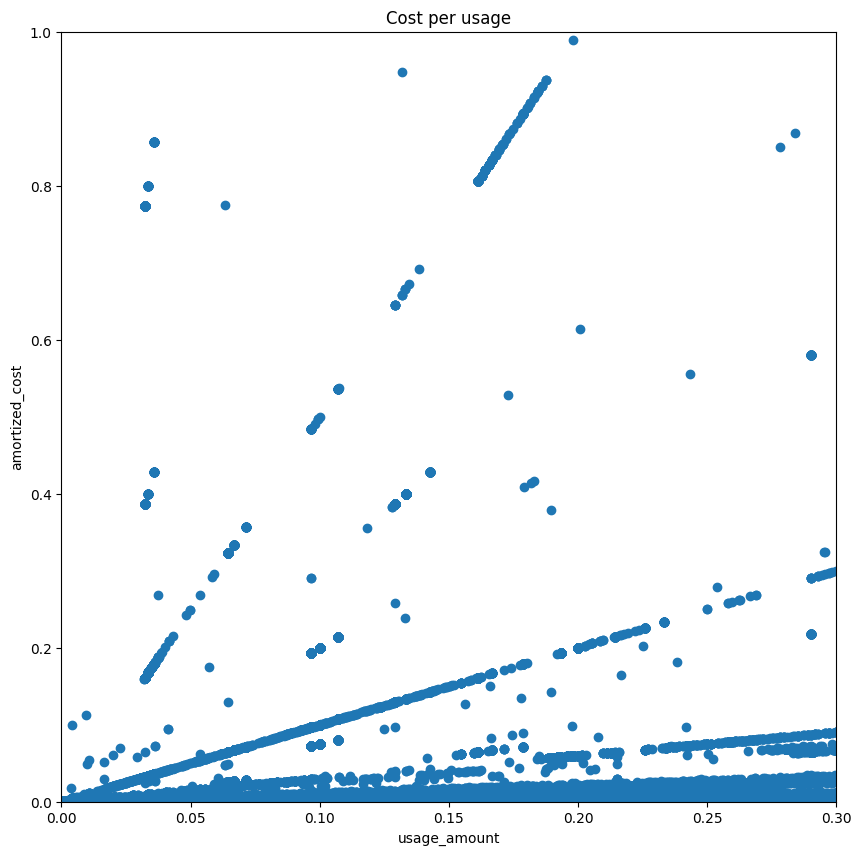

In [29]:
# relationship of usage with cost, values filtered to be closer to the median (on the usage), so that we can try to extrapolate something

mpl.rcParams['agg.path.chunksize'] = 10000

plt.figure(figsize=(10,10))
plt.scatter(df4['usage_amount'], df4['amortized_cost'])
plt.xlabel('usage_amount')
plt.ylabel('amortized_cost')
plt.ylim((0, 1))
plt.xlim((0, 0.30))
plt.title('Cost per usage')

plt.show()

By analysing the above graph, we conclude it's not easy to find a direct relationship between these 2 variables. On one hand, we see one line that indicates a positive correlation between them (whenever the usage goes up, the costs as well), but we see a lot of free usage as well, where we use free products, most likely, or, on the other hand, we have can have little usage and spend a lot (more expensive products).

#### *Line Item type*

This variable indicates us what type of service are we using. It's pretty simple with only 4 distinct classes and let's see if it's useful for discovering relations with the dependent variable.

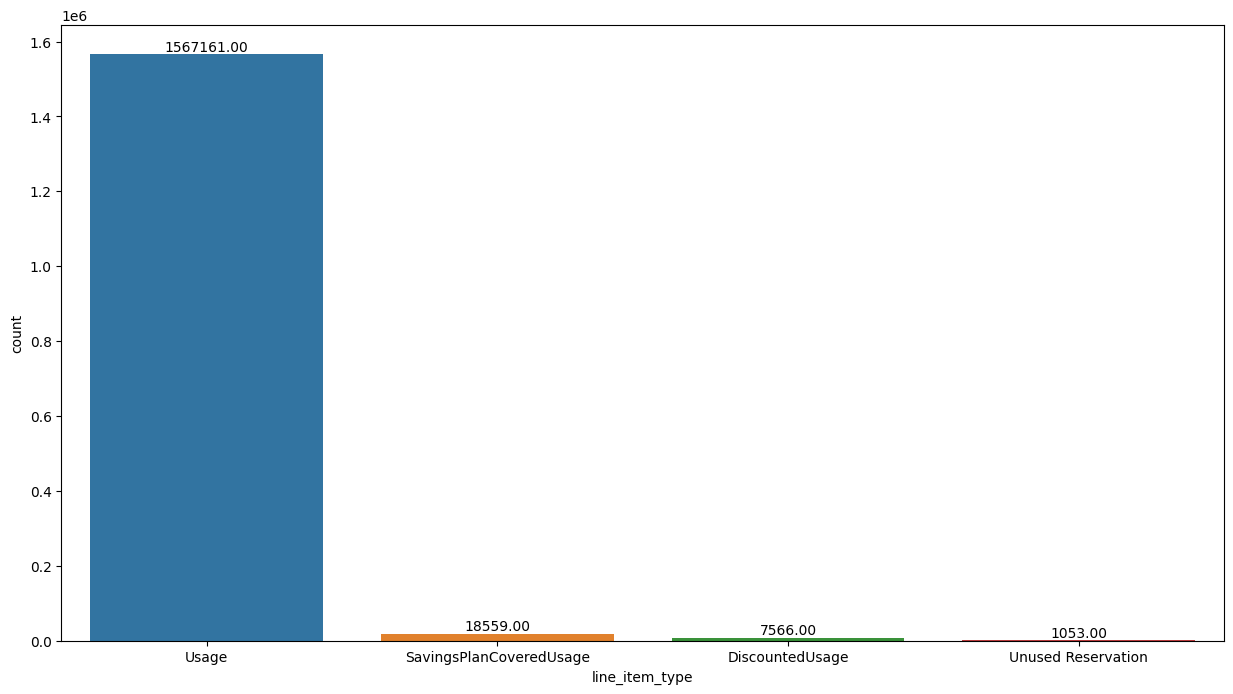

In [30]:
plt.figure(figsize=(15,8))
splot = sns.countplot(x="line_item_type",data=df4)
for p in splot.patches:
  splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

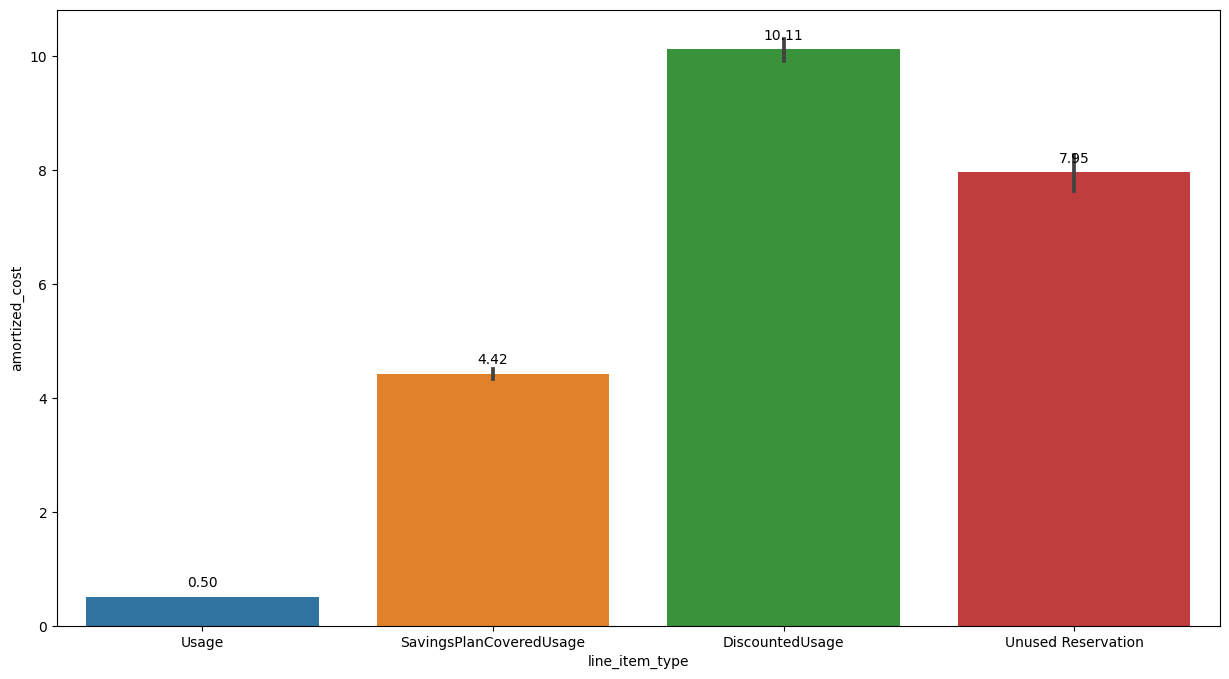

In [31]:
plt.figure(figsize=(15,8))
splot = sns.barplot(data=df4, x="line_item_type", y="amortized_cost")
for p in splot.patches:
  splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

As we see, there is a huge dominance in "Usage" kind of line item with more than 98% of totalcount of rows. As far as cost is concerned, we see actually being the category with the least average of it (probably most of them happen when we have free costs (=0)). **This means, that it can be useful to still consider this variable instead of just ignoring it. However, we will merge all other 3 values into one - "other"**. Still, later, it's useful to discover if this new category has some meaning whatsoever.

In [32]:
df5 = df4.copy()
df5['line_item_type'] = np.where(df5['line_item_type'] != 'Usage', 'Other', df5['line_item_type'])
df5.groupby('line_item_type', dropna=False).agg({'amortized_cost':'count', 'usage_amount':'sum'}).reset_index()

,line_item_type,amortized_cost,usage_amount
0,Other,27178,4.007335e+06
1,Usage,1567161,2.891863e+09


#### *Product Code*

This variable indicates us what AWS service/product was used on each daily operation. It contains 58 distinct values right now, so let's assess its relevance and distribution.

In [33]:
product_grouped = df5.groupby('product_code', dropna=False).agg({'amortized_cost':['count', 'sum']}).reset_index()#.sort_values('amortized_cost', ascending=False)
product_grouped.columns = product_grouped.columns.map('_'.join)
product_grouped['pct_count'] = round(product_grouped['amortized_cost_count'] * 100/sum(product_grouped['amortized_cost_count']), 1)
product_grouped['pct_cost'] = round(product_grouped['amortized_cost_sum'] * 100/sum(product_grouped['amortized_cost_sum']), 1)#.sort_values('pct_cost', ascending=False)
product_grouped = product_grouped.sort_values('pct_cost', ascending=False)
product_grouped

,product_code_,amortized_cost_count,amortized_cost_sum,pct_count,pct_cost
25,AmazonEC2,322740,261988.801619,20.2,27.4
42,AmazonRDS,36447,218465.291131,2.3,22.9
29,AmazonES,10895,78886.851363,0.7,8.3
24,AmazonDynamoDB,31810,68674.974522,2.0,7.2
21,AmazonCloudWatch,47080,59246.317399,3.0,6.2
45,AmazonS3,615221,56623.530287,38.6,5.9
9,AWSELB,80837,35449.367044,5.1,3.7
38,AmazonMSK,4886,35289.066575,0.3,3.7
31,AmazonElastiCache,7232,27545.045000,0.5,2.9
17,AWSTransfer,3435,22312.577065,0.2,2.3


In [34]:
# what if we choose just the values which appear either more than 1% of total rows or total costs?
pg_new = product_grouped[(product_grouped['pct_count'] > 1) | (product_grouped['pct_cost'] > 1)]
pg_new

,product_code_,amortized_cost_count,amortized_cost_sum,pct_count,pct_cost
25,AmazonEC2,322740,261988.801619,20.2,27.4
42,AmazonRDS,36447,218465.291131,2.3,22.9
29,AmazonES,10895,78886.851363,0.7,8.3
24,AmazonDynamoDB,31810,68674.974522,2.0,7.2
21,AmazonCloudWatch,47080,59246.317399,3.0,6.2
45,AmazonS3,615221,56623.530287,38.6,5.9
9,AWSELB,80837,35449.367044,5.1,3.7
38,AmazonMSK,4886,35289.066575,0.3,3.7
31,AmazonElastiCache,7232,27545.045000,0.5,2.9
17,AWSTransfer,3435,22312.577065,0.2,2.3


As we can see, the dominance in this field is not so high as the previous one. However, there are a lot of irrelevant values whether because they are not representative in the whole column or they don't have many costs associated.
What we will do, in this case, is to take the first 20 values (representing more than 1% of either costs or count) and the remaining we put as "other").

In [35]:
df6 = df5.copy()
df6['product_code'] = np.where(df6['product_code'].isin(list(pg_new['product_code_'])), df6['product_code'], 'Other')
df6.groupby('product_code', dropna=False).agg({'amortized_cost':'count', 'usage_amount':'sum'}).reset_index()

,product_code,amortized_cost,usage_amount
0,AWSCloudTrail,23726,4.215475e+08
1,AWSELB,80837,1.430684e+06
2,AWSLambda,55529,2.323889e+07
3,AWSQueueService,33030,4.321928e+08
4,AWSSecretsManager,22449,4.273730e+07
5,AWSTransfer,3435,7.488000e+04
6,AmazonCloudFront,59097,1.884164e+08
7,AmazonCloudWatch,47080,2.759563e+08
8,AmazonDynamoDB,31810,2.183182e+08
9,AmazonEC2,322740,8.589455e+06


#### *Line Item Description*

This variable contains 2 kinds of info in the same string:
- the cost per something (some unit usage)
- the place where it was (an instance, a country, etc).

As we are going to see now, this information can be irrelevant for the fact that we might have the cost per usage now (it's basically the 2 variables we have divided) - **so can be redudant to have this data again** and the remaining can be incorporated in other variables already directly. Also, there are a lot of different values in this field which can create too much noise to our models.

In [36]:
# let's confirm that the cost per unit is similar to what we have already as a ratio

df_lid = df6[['amortized_cost', 'usage_amount', 'line_item_description']].copy()

df_lid['description_price'] = df_lid.line_item_description.str.extract('([0-9][.]*[0-9]*)').astype('float')
df_lid['price_per_unit'] = np.round(np.where(df_lid['usage_amount'] == 0, 0, df_lid['amortized_cost']/df_lid['usage_amount']).astype('float'), 3)
df_lid.head(5)

,amortized_cost,usage_amount,line_item_description,description_price,price_per_unit
0,2.459866,245.986809,$0.010 per GB - regional data transfer - in/ou...,0.010,0.010
1,1.513749,50.458333,$0.03 per GB-mo of log storage - US East (Nort...,0.030,0.030
2,0.000248,620.000000,"$0.004 per 10,000 GET and all other requests",0.004,0.000
3,0.187315,23.414373,$0.008 per used Application load balancer capa...,0.008,0.008
4,0.000000,1.000000,"$0.004 per 10,000 GET and all other requests",0.004,0.000


In [37]:
df_lid.describe().T

,count,mean,std,min,25%,50%,75%,max
amortized_cost,1594339.0,0.598850,2.925657,0.000000,0.000000,0.000003,0.000604,33.965591
usage_amount,1594339.0,1816.345483,12576.616738,0.000001,0.000056,0.273226,44.000000,221676.000000
description_price,1578647.0,0.576683,9.459154,0.000000,0.003600,0.020000,0.090000,750.000000
price_per_unit,1594339.0,0.047564,0.363022,0.000000,0.000000,0.000000,0.020000,24.000000


In [38]:
lid_grouped = df6.groupby('line_item_description', dropna=False).agg({'amortized_cost':['count', 'sum']}).reset_index()
lid_grouped.columns = lid_grouped.columns.map('_'.join)
lid_grouped['pct_count'] = round(lid_grouped['amortized_cost_count'] * 100/sum(lid_grouped['amortized_cost_count']), 1)
lid_grouped['pct_cost'] = round(lid_grouped['amortized_cost_sum'] * 100/sum(lid_grouped['amortized_cost_sum']), 1)
lid_grouped = lid_grouped.sort_values('pct_count', ascending=False)
lid_grouped

,line_item_description_,amortized_cost_count,amortized_cost_sum,pct_count,pct_cost
755,$0.090 per GB - first 10 TB / month data trans...,158174,20025.321238,9.9,2.1
347,"$0.004 per 10,000 GET and all other requests",109234,58.215720,6.9,0.0
355,"$0.0044 per 10,000 GET and all other requests",42899,43.336548,2.7,0.0
299,$0.000 per GB - data transfer in per month,41254,0.000000,2.6,0.0
536,$0.02 per GB - US East (Northern Virginia) dat...,38018,434.499937,2.4,0.0
...,...,...,...,...,...
480,$0.02 per GB - EU (Germany) data transfer to U...,8,0.000023,0.0,0.0
483,$0.02 per GB - EU (Ireland) data transfer to A...,142,0.000000,0.0,0.0
484,$0.02 per GB - EU (Ireland) data transfer to A...,6,0.000000,0.0,0.0
485,$0.02 per GB - EU (Ireland) data transfer to A...,7,0.000000,0.0,0.0


To conclude, we see that the price per unit seems to match the amount of amortized cost per usage amount (and what we have as usage_amount seem to match the amount of GBs consumed).  Also, the values are really spread out and with few meaning for all (there is no dominant distinct value).
**Therefore, it looks like this variable might be irrelevant to our work.**

#### *Usage Type*

This variable is related with another AWS service detail. Its mode is "Data Volume" and let's see remaining cardinality distribution.

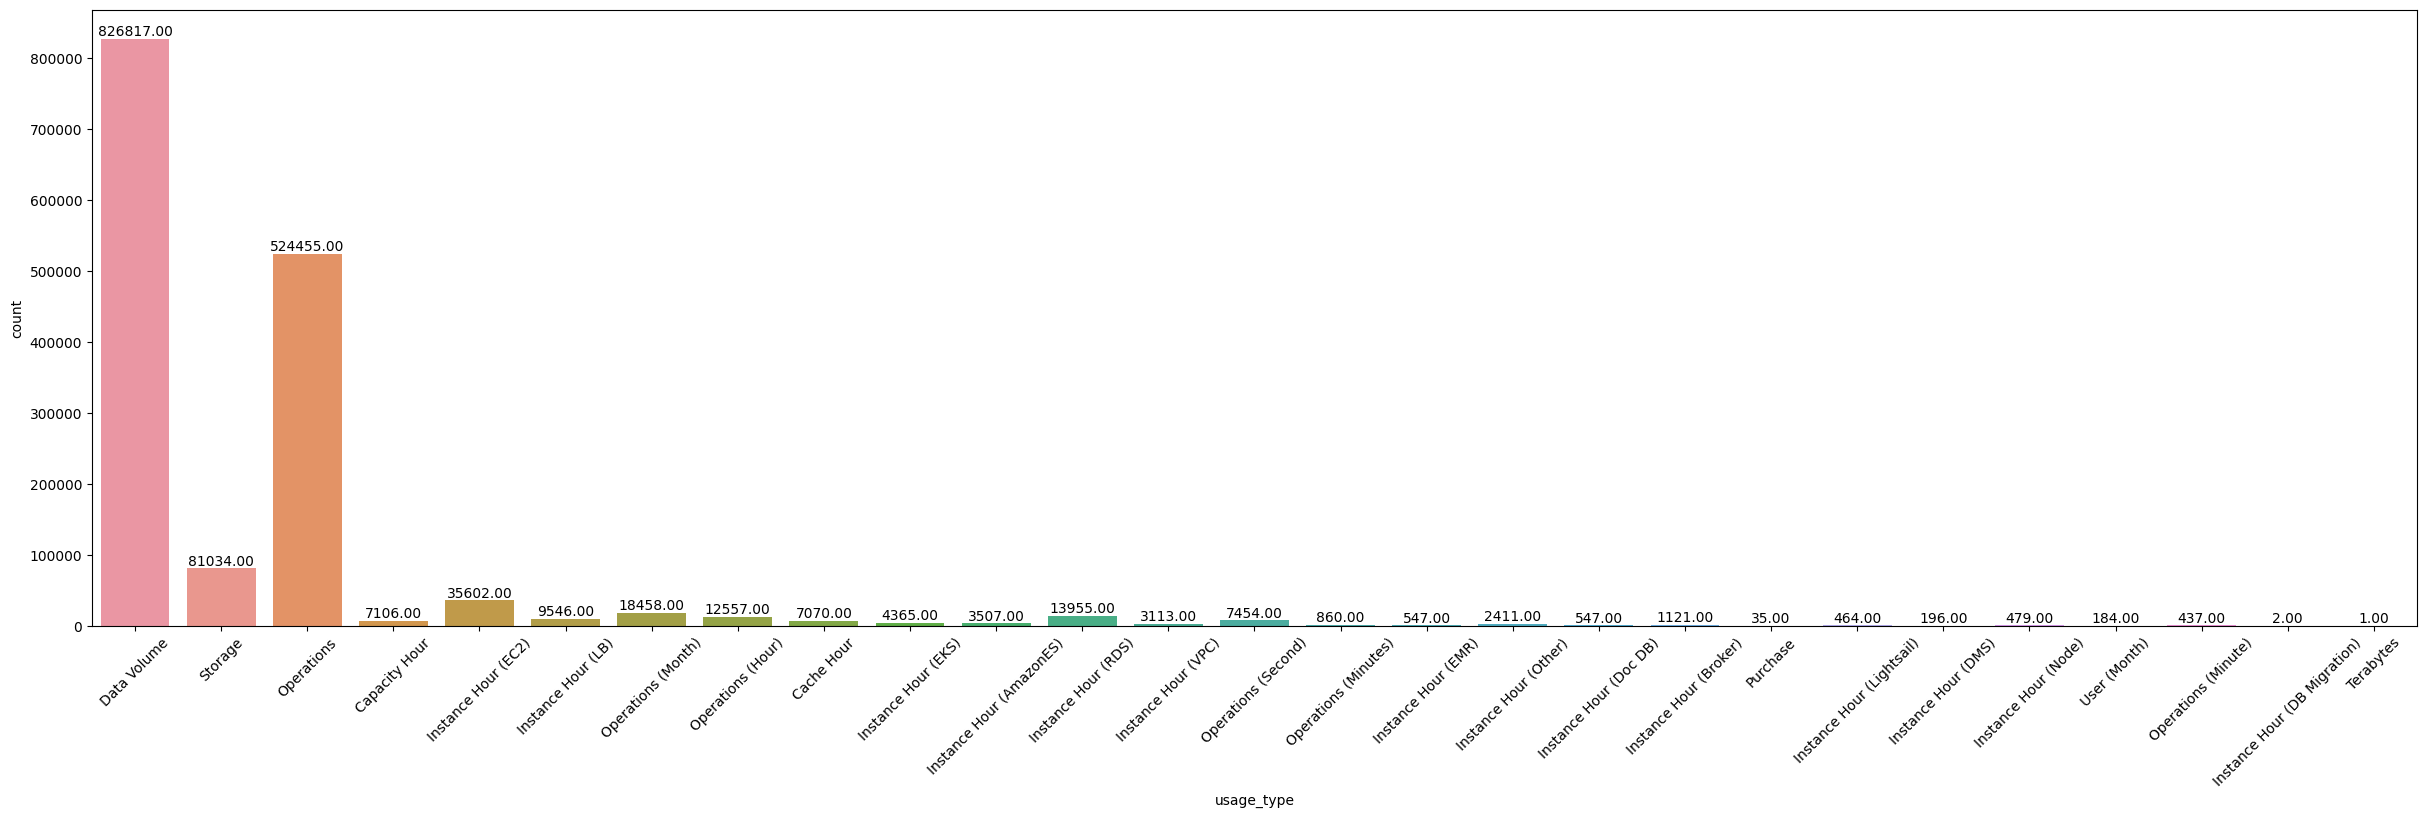

In [39]:
plt.figure(figsize=(30,8))
splot = sns.countplot(x="usage_type",data=df6)
for p, item in zip(splot.patches, splot.get_xticklabels()):
  splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
  item.set_rotation(45)

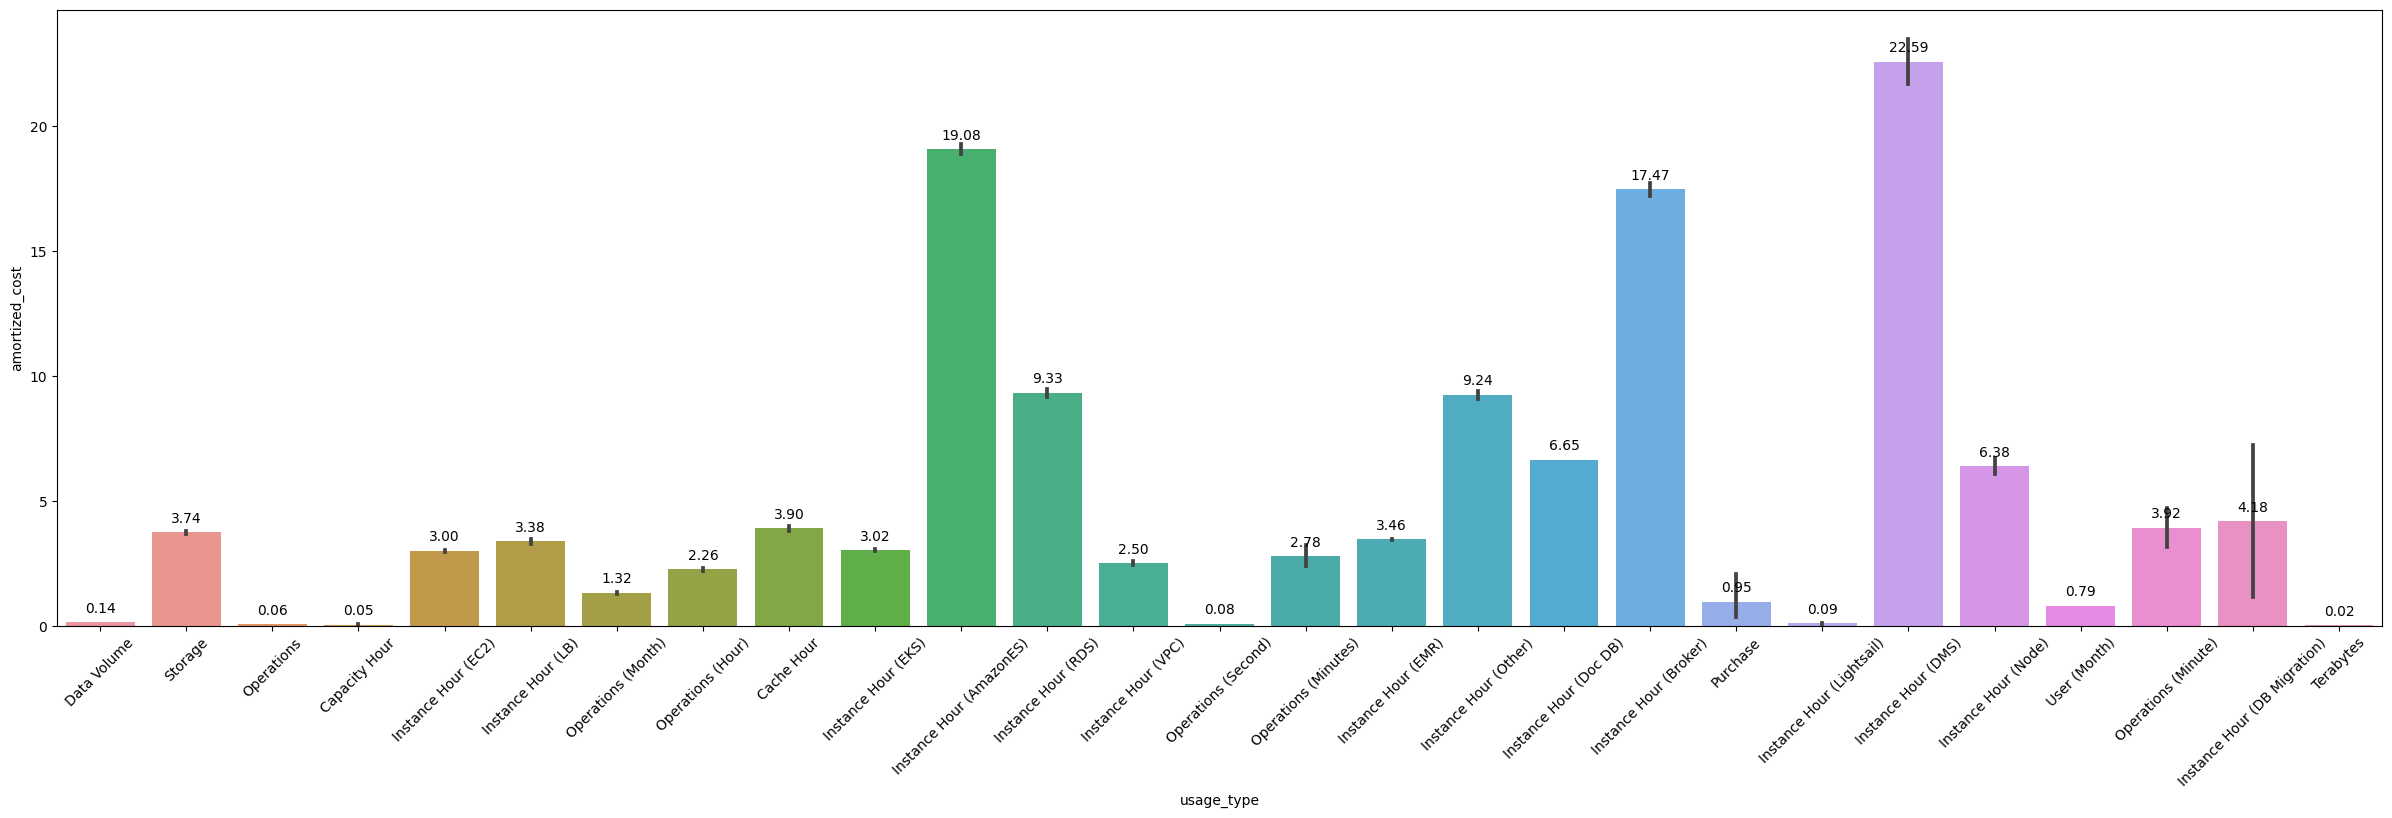

In [40]:
# relate with the cost variable
plt.figure(figsize=(30,8))
splot = sns.barplot(data=df6, x="usage_type", y="amortized_cost")
for p, item in zip(splot.patches, splot.get_xticklabels()):
  splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
  item.set_rotation(45)

As we see, there is a **dominance** in terms of value distribution within its class in **"Data Volume" and "Operations"**. This doesn't translate into higher average costs of course, as we know that the majority of costs are close to 0.
- We observe, as well, that we have some "Operations" values related between them (specifying the time span in parenthesis), but probably grouping all of them is a good idea. Same applies to the "Instance Hour" values.
- We have some nulls in our dataset that by itself might not have the most impact but still, can be useful so we'll keep them.
- We will aggregate the remaining values to "Other" as well as the nulls!

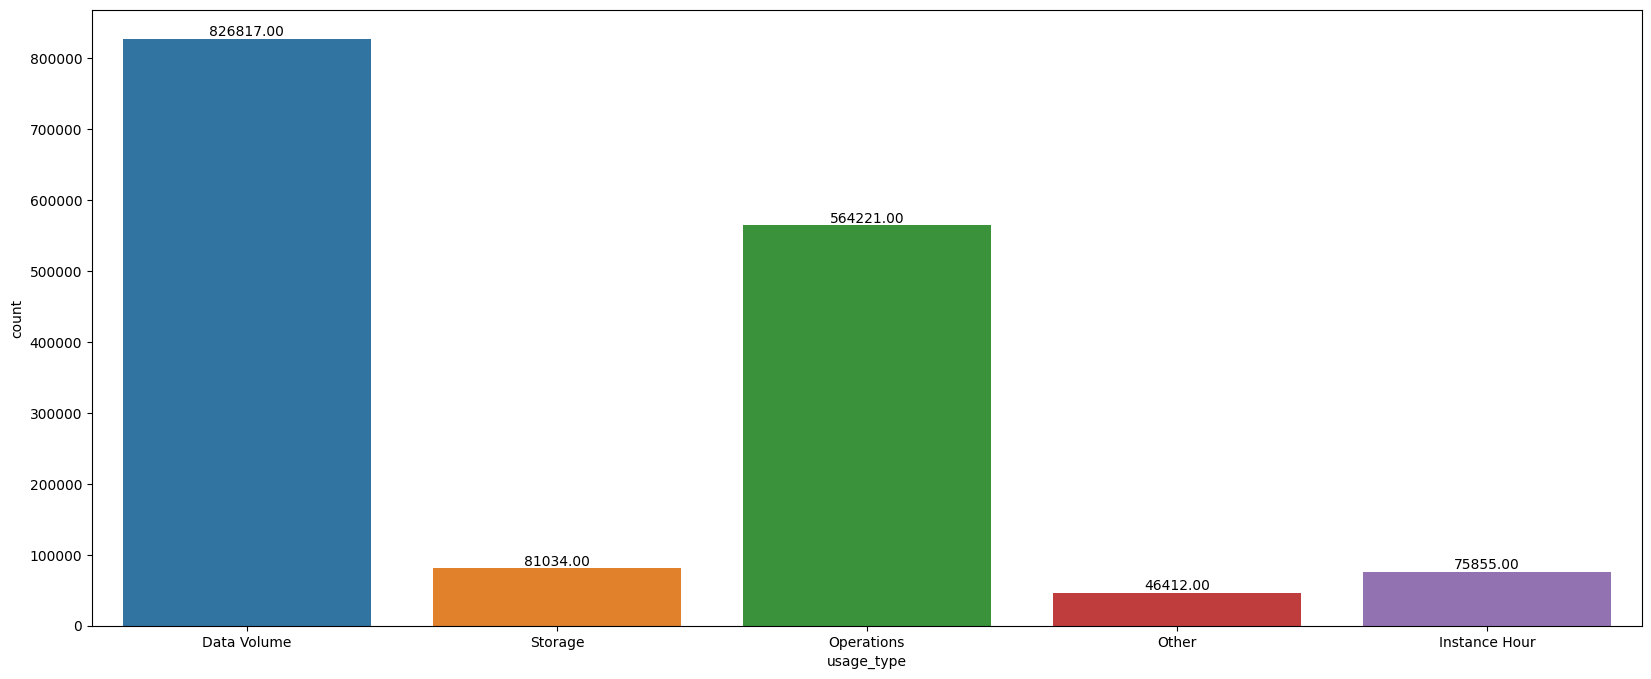

In [41]:
df7 = df6.copy()
df7['usage_type'] = df7['usage_type'].fillna('Other')
df7['usage_type'] = np.where(df7['usage_type'].str.contains('Operations'), 'Operations', df7['usage_type'])
df7['usage_type'] = np.where(df7['usage_type'].str.contains('Instance Hour'), 'Instance Hour', df7['usage_type'])

list_to_keep = ['Operations', 'Data Volume', 'Storage', 'Instance Hour']
df7['usage_type'] = np.where(df7['usage_type'].isin(list_to_keep), df7['usage_type'], 'Other')


plt.figure(figsize=(20,8))
splot = sns.countplot(x="usage_type",data=df7)
for p in splot.patches:
  splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

#### *Usage Type AWS*

This variable is related with the previous one but with a lot of cardinality, just like the "line_item_description".

In [42]:
df_uta = df7[['amortized_cost', 'usage_amount', 'usage_type', 'usage_type_aws']].copy()

top_values = df_uta.groupby('usage_type_aws', dropna=False).agg({'amortized_cost':['count', 'sum']}).reset_index()
top_values.columns = top_values.columns.map('_'.join)
top_values = top_values.sort_values('amortized_cost_count', ascending=False)
top_values.head(20)


,usage_type_aws_,amortized_cost_count,amortized_cost_sum
686,Requests-Tier2,80305,52.620609
222,DataTransfer-Out-Bytes,68148,6795.336118
1037,USW1-DataTransfer-Out-Bytes,43181,13207.420836
1152,USW1-Requests-Tier2,42899,43.336548
216,DNS-Queries,42505,157.625293
879,USE1-USW2-AWS-Out-Bytes,38018,434.499937
381,EUC1-DataTransfer-Out-Bytes,27684,1413.032381
476,EUC1-Requests-Tier2,25224,9.269738
1151,USW1-Requests-Tier1,22125,920.772361
1182,USW1-USW2-AWS-Out-Bytes,21552,35.704057


As seen with the top 20 values in terms of frequency, we have some options to deal with this column:
- First, we can specify the type of usage, so for instance have values like "Requests - Tiers2, DataTransfer-Out-Bytes, DNS-Queries, etc etc";
- OR, we can split and create a new column with the info of the name of the server where the data is being moved: "USW1, EUC1, etc etc".


**The problem here is that there are many correlated values within each distribution (for instance we can have EUC1 server, but on other we have EUC1-USW2), which can indicate that both servers have interactions here.**

Even if we do treatments, it's difficult to get to a correct distribution or else we get a high cardinality still without any dominant value. **Thus, it's better to leave out this variable for now.**

In [43]:
################# test to use usage type aws for server - will not be used

df8 = df7.copy()

# get either the left string before the first '-' or ':'. Also, put it all uppercase so we dont have discrepancies
df8['server'] = df8['usage_type_aws'].str.replace(':', '-').str.split('-').str[0]
df8['server'] = df8['server'].str.upper()
uta_group = df8.groupby('server', dropna=False).agg({'amortized_cost':'count', 'usage_amount':'sum'}).reset_index()
uta_group

,server,amortized_cost,usage_amount
0,AGENT,86,2.039000e+03
1,AP,13417,1.646878e+07
2,APN1,5592,2.177474e+07
3,APN2,4735,2.142462e+07
4,APN3,4390,2.104246e+07
...,...,...,...
82,USW1,313265,4.990666e+08
83,USW2,111323,1.109155e+08
84,VPN,379,2.726700e+04
85,WRITEREQUESTUNITS,110,1.586845e+07


#### *Operation*

This variable indicates us other detail of an AWS service. Right now, after cleaning, it contains only 1 null and 354 distinct values which is quite a high number. Let's see how can we fix this possible issue.

In [44]:
op_grouped = df7.groupby('operation', dropna=False).agg({'amortized_cost':['count', 'sum']}).reset_index()
op_grouped.columns = op_grouped.columns.map('_'.join)
op_grouped = op_grouped.sort_values('amortized_cost_sum', ascending=False)
op_grouped.head(20)

,operation_,amortized_cost_count,amortized_cost_sum
34,CreateDBInstance:0002,16103,133272.589970
276,RunInstances,188193,113825.396012
300,StandardStorage,15046,80461.819579
93,ESDomain,5631,78878.174615
45,CreateSnapshot,4152,44908.187797
201,NatGateway,11948,40717.857220
36,CreateDBInstance:0014,10006,37671.920222
31,CreateCacheCluster:0002,6523,27321.869000
49,CreateVolume-Gp3,3920,23852.923696
33,CreateDBInstance,2927,19752.868050


**We can do similar treatments here as done in the past.** First, lets consider all strings before ":" or "-", because we have operations like "CreateDBInstance:0002" and "	CreateDBInstance:0014", for instance, which might not be so relevant to distinguish this detail. So, we'll group them all and, then, we'll consider a large cumulative percentage of distincts and then treat remaining categories as "Other".

In [45]:
df8 = df7.copy()

# the null = 'unknown' because its a meaning of a null and we have 'None' and 'none' in the dataset which mean the same
df8['operation'] = df8['operation'].fillna('Unknown')
df8['operation'] = df8['operation'].str.replace(':', '-').str.split('-').str[0]
df8['operation'] = df8['operation'].str.replace('none', 'None')
op_grouped_treated = df8.groupby('operation', dropna=False).agg({'amortized_cost':['count', 'sum']}).reset_index()
op_grouped_treated.columns = op_grouped_treated.columns.map('_'.join)
op_grouped_treated = op_grouped_treated.sort_values('amortized_cost_count', ascending=False)

op_grouped_treated['pct_count'] = (op_grouped_treated['amortized_cost_count']/sum(op_grouped_treated['amortized_cost_count']))*100
op_grouped_treated['pct_cost'] = (op_grouped_treated['amortized_cost_sum']/sum(op_grouped_treated['amortized_cost_sum']))*100
op_grouped_treated['count_cumsum'] = round(op_grouped_treated['pct_count'].cumsum(), 1)

op_grouped_treated

,operation_,amortized_cost_count,amortized_cost_sum,pct_count,pct_cost,count_cumsum
249,RunInstances,190131,115106.581418,11.925381,1.205596e+01,11.9
168,LoadBalancing,80837,35449.367044,5.070252,3.712872e+00,17.0
195,PublicIP,78199,719.441014,4.904791,7.535233e-02,21.9
214,ReadACL,73352,9.317318,4.600778,9.758710e-04,26.5
204,PutObject,72788,327.707989,4.565403,3.432326e-02,31.1
...,...,...,...,...,...,...
159,ListSMSSandboxPhoneNumbers,1,0.000000,0.000063,0.000000e+00,100.0
246,RunAnalysis,1,0.300000,0.000063,3.142120e-05,100.0
103,GetOpsSummary,1,0.000117,0.000063,1.225427e-08,100.0
291,UpdateKeyDescription,1,0.000000,0.000063,0.000000e+00,100.0


In [46]:
# Let's define a 90% threshold on the 'count_cumsum' column to retain the distinct categories and the remaining will be 'Other'

op_list_keep = list(op_grouped_treated[(op_grouped_treated['count_cumsum'] <= 90)]['operation_'])
len(op_list_keep)


87

In [47]:
df8['operation'] = np.where(df8['operation'].isin(op_list_keep), df8['operation'], 'Other')
df8.groupby('operation', dropna=False).agg({'amortized_cost':'count', 'usage_amount':'sum'}).reset_index()

,operation,amortized_cost,usage_amount
0,A,4053,9.863848e+07
1,CAA,3028,2.931751e+06
2,CNAME,3840,5.913634e+07
3,ClientVPNConnections,11382,6.213963e+04
4,CompleteMultipartUpload,10354,4.136405e+07
...,...,...,...
83,StandardStorage,15046,1.233242e+06
84,TXT,2981,5.733776e+07
85,Unknown,22411,6.094266e+04
86,UploadPart,8740,5.469486e+07


**We managed to keep still a high cardinality (88 distinct values) but more manageable now!**

#### *Environment Tag*

This variable is now related with which portions of the client infrastructure are using the services and what's their work environment. Pretty straigthforward with 15 distinct string values but with a lot of nulls. Let's inspect:

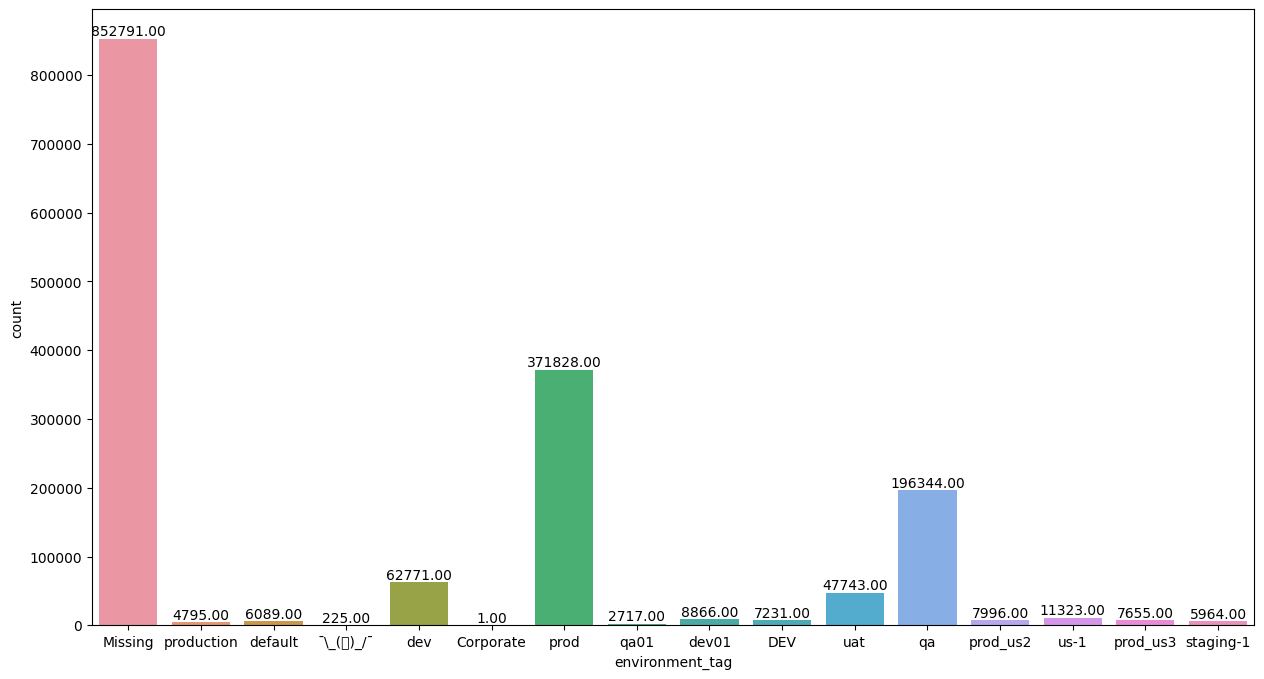

In [48]:
plt.figure(figsize=(15,8))
splot = sns.countplot(x="environment_tag",data=df8.fillna('Missing'))
for p in splot.patches:
  splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

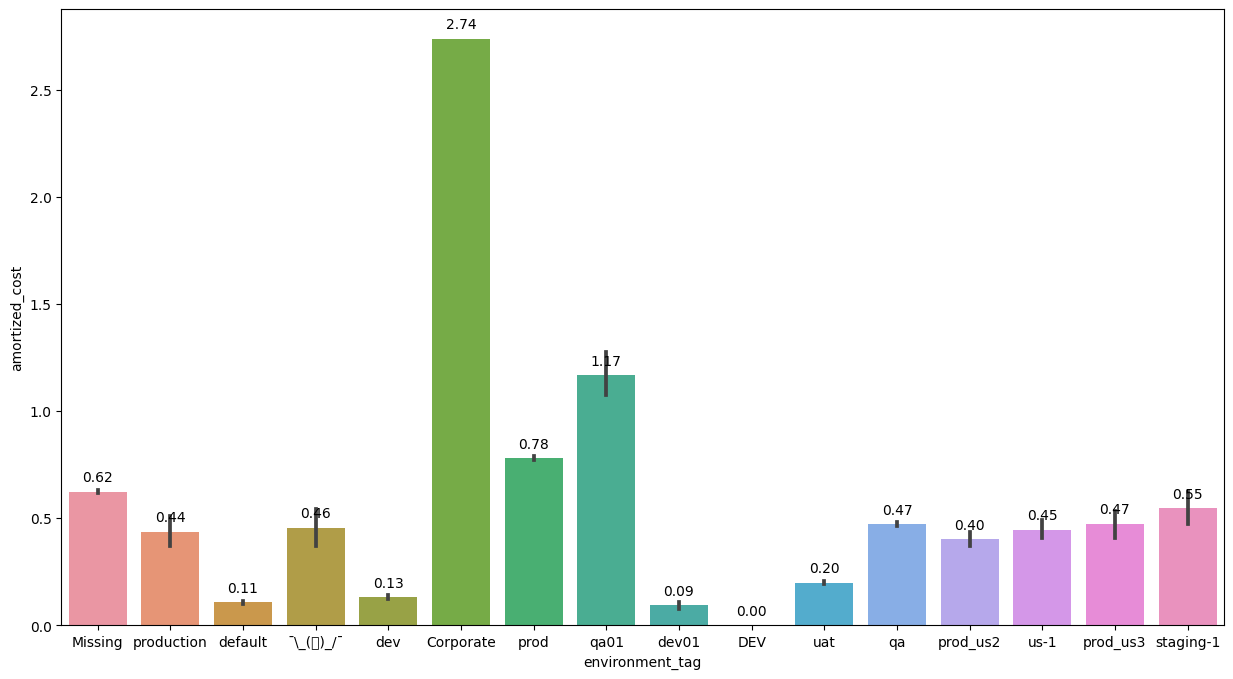

In [49]:
plt.figure(figsize=(15,8))
splot = sns.barplot(data=df8.fillna('Missing'), x="environment_tag", y="amortized_cost")
for p in splot.patches:
  splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Some interesting results we have here:
- First, the nulls dominate our distribution
- We have a '¯\_(ツ)_/¯' value which is comic and it can be relatable to the nulls as well (we don't know either), so let's group them and call it 'Unknown'
- Like other cols, some values here can be aggregated so that we have less environment tags.

In [50]:
df9 = df8.copy()

df9['environment_tag'] = df9['environment_tag'].fillna('unknown') # fill nulls
df9['environment_tag'] = df9['environment_tag'].str.replace('¯\_(ツ)_/¯', 'unknown', regex=False) # replace other value to match nulls
df9['environment_tag'] = df9['environment_tag'].str.replace('production', 'prod') # replace production to prod
df9['environment_tag'] = df9['environment_tag'].str.replace('_', '-').str.split('-').str[0] # take left of '_' or '-'
df9['environment_tag'] = df9['environment_tag'].str.replace('01', '') # remove numbers from string
df9['environment_tag'] = df9['environment_tag'].str.replace('us', 'unknown') # put the "us" values into the "unknown" category because we don't know his environment still
df9['environment_tag'] = df9['environment_tag'].str.lower() # lowercase all
df9 = df9[df9['environment_tag'] != 'corporate']# remove "corporate" row as it is only 1 observation and it quite some cost, so can be seen as outlier (also, this might not be a valid environment tag)

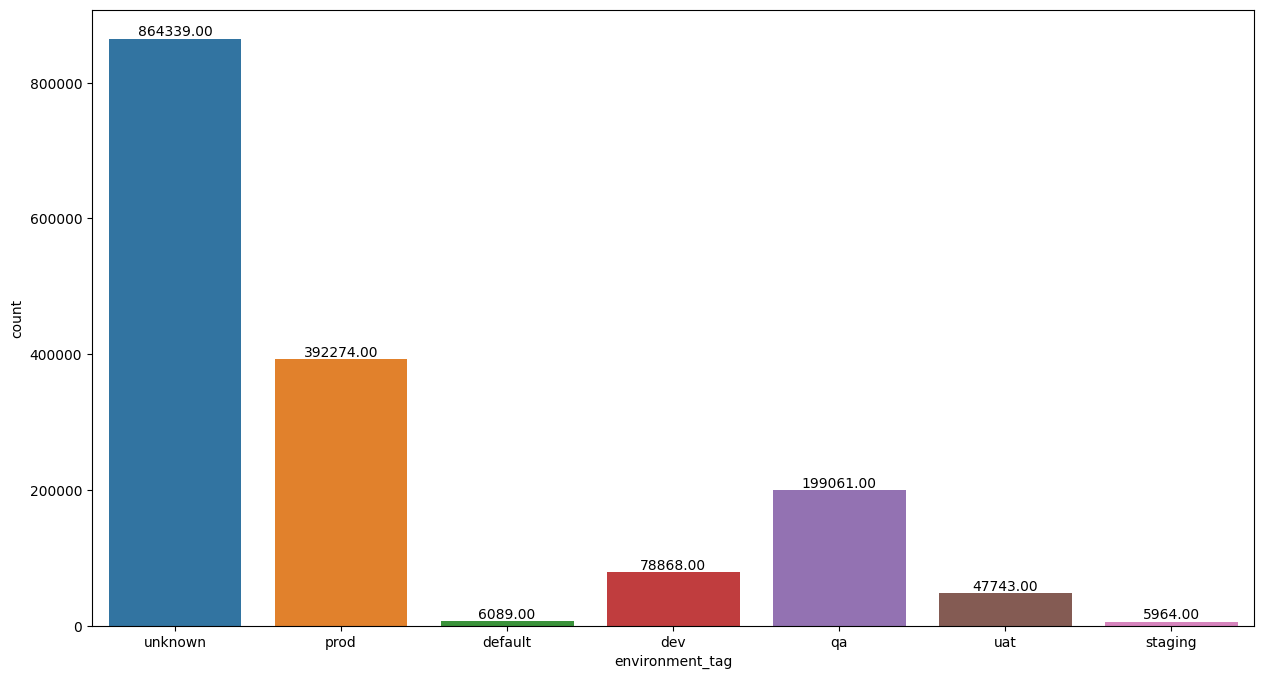

In [51]:
plt.figure(figsize=(15,8))
splot = sns.countplot(x="environment_tag",data=df9)
for p in splot.patches:
  splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

#### *Product Tag*

This is the final independent variable and crutial for our forecast model. As requested, we have to include at least this attribute to the model, so, let's check its importance:

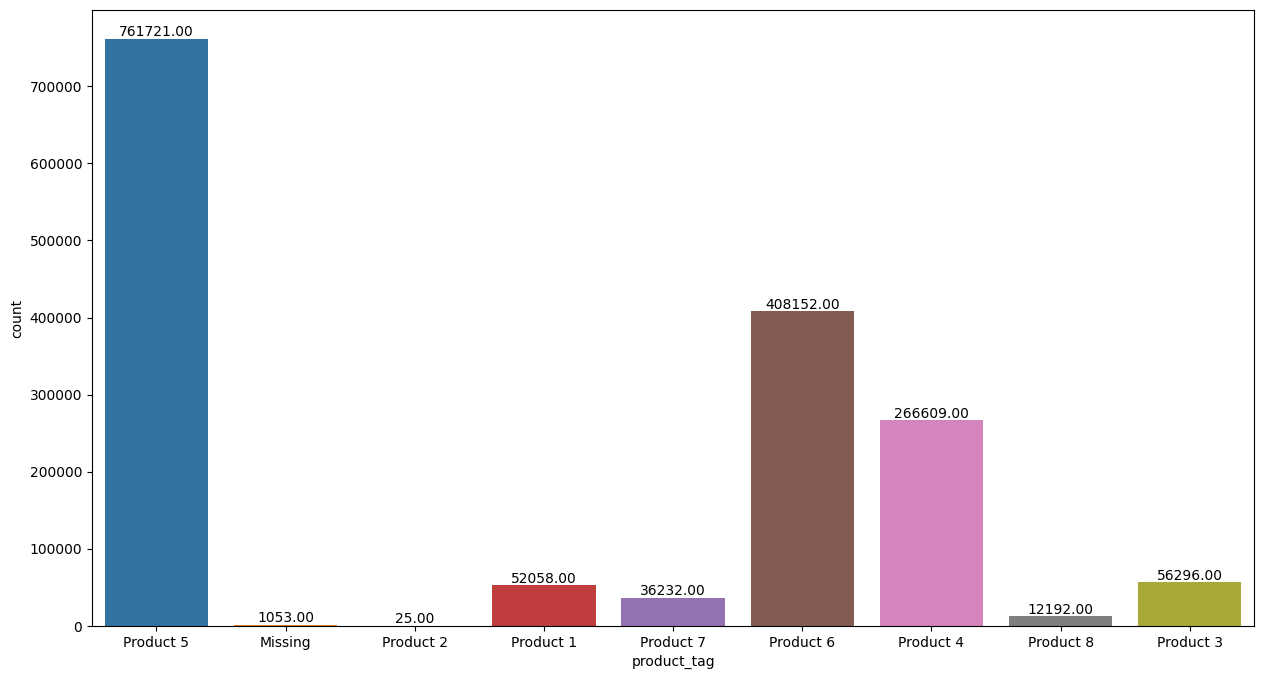

In [52]:
plt.figure(figsize=(15,8))
splot = sns.countplot(x="product_tag",data=df9.fillna('Missing'))
for p in splot.patches:
  splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

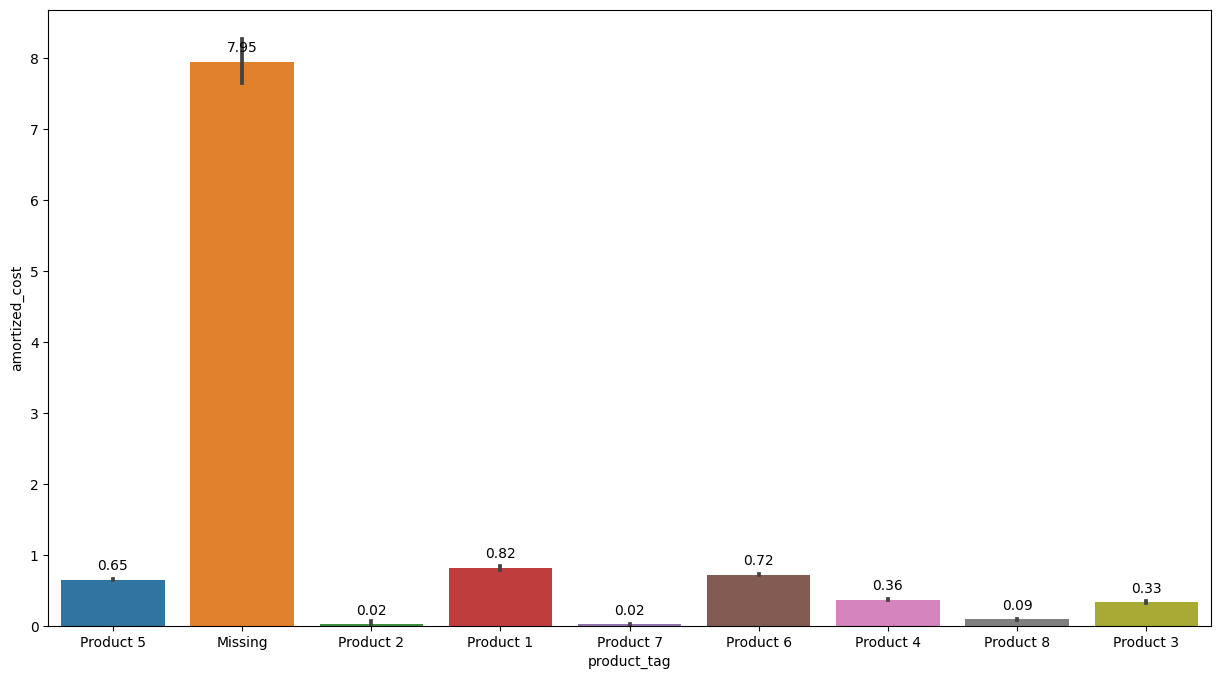

In [53]:
plt.figure(figsize=(15,8))
splot = sns.barplot(data=df9.fillna('Missing'), x="product_tag", y="amortized_cost")
for p in splot.patches:
  splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

As we see above, the values range from "Product 1" to "Product 8". The Product 2 doesnt have any relevance so, we can remove those small lines.
**As far as the nulls are concerned, it's "safe" to remove them as well, since they contain no meaningful importance and they can bias the forecast as well, since the mean for the amortized cost is quite high when compared to all the other values (outlier)**. We'll keep the other categories as they are even though some might have smaller expression in the data we have.

In [54]:
df10 = df9.copy()

df10 = df10[~((df10['product_tag'].isnull()) | (df10['product_tag'] == 'Product 2'))]

summary(df10)

,count_non_nulls,count_nulls,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
usage_date,1593260,0,547,2023-01-25 00:00:00,4385,2021-10-01,2023-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
line_item_type,1593260,0,2,Usage,1567136,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_code,1593260,0,21,AmazonS3,615219,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
line_item_description,1593260,0,1221,$0.090 per GB - first 10 TB / month data trans...,158170,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage_type,1593260,0,5,Data Volume,826808,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage_type_aws,1593260,0,1362,Requests-Tier2,80305,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
operation,1593260,0,88,RunInstances,190105,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environment_tag,1593260,0,7,unknown,863261,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_tag,1593260,0,7,Product 5,761721,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amortized_cost,1593260.0,0.0,NaN,NaN,NaN,NaT,NaT,0.593996,2.917597,0.0,0.0,0.000003,0.000594,33.965591


### New features - One Hot Encoding

Now, to turn our models more efficient or even possible (in case of a time series regression), we have to transform the categorical variables into int variables. To do this, we can do several ways, namely by:
- Encoding our data and creating a multi flag inside each column, which lowers the dimensionality but it might "confuse" our models (in the sense that higher number cardinality doesn't mean anything in this case);
- Target encoding, which actually could be very useful and it keeps the dimensionality low as well (it's like the previous method but it weights regarding the distribution of values in each class)
- **One Hot Encoding**, which is basically creating multiple binary flags representing each class of each variable.
This is a very popular method, so let's check its appeal.

In [55]:
# But first, remove the 2 columns and groupby all the others so we have less volumetry
df11 = df10.copy()

df11 = df11.drop(columns = ['line_item_description', 'usage_type_aws'])

df11 = df11.groupby([c for c in df11.columns if c not in ['amortized_cost', 'usage_amount']], dropna=False)\
             .agg({'amortized_cost':'sum', 'usage_amount':'sum'}).reset_index()

summary(df11)

,count_non_nulls,count_nulls,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
usage_date,388364,0,547,2023-01-25 00:00:00,1370,2021-10-01,2023-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
line_item_type,388364,0,2,Usage,382657,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_code,388364,0,21,AmazonS3,201436,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage_type,388364,0,5,Operations,209406,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
operation,388364,0,88,Other,34200,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environment_tag,388364,0,7,unknown,139977,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_tag,388364,0,7,Product 6,113091,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,388364.0,0.0,NaN,NaN,NaN,NaT,NaT,6.54633,3.811209,1.0,3.0,7.0,10.0,12.0
quarter,388364.0,0.0,NaN,NaN,NaN,NaT,NaT,2.493534,1.245668,1.0,1.0,3.0,4.0,4.0
weekday,388364.0,0.0,NaN,NaN,NaN,NaT,NaT,2.981152,1.983908,0.0,1.0,3.0,5.0,6.0


**Voilá! The volumetry of the database drastically changed when we removed both columns and by changing the granularity to a higher level, we have much less rows (around 388k)**, which can improve our models' performance. However, this has a cost where we can loose information of each single point with both removed columns information.

In [56]:
df_encoded = pd.get_dummies(df11, columns = ['line_item_type', 'product_code', 'usage_type', 'operation', 'environment_tag', 'product_tag'])

# replace spaces in col names with "_" and lowercase it
df_encoded.columns = df_encoded.columns.str.replace(' ','_')
df_encoded.columns = df_encoded.columns.str.lower()

print(df_encoded.columns)

Index(['usage_date', 'month', 'quarter', 'weekday', 'amortized_cost',
       'usage_amount', 'line_item_type_other', 'line_item_type_usage',
       'product_code_awscloudtrail', 'product_code_awselb',
       ...
       'environment_tag_staging', 'environment_tag_uat',
       'environment_tag_unknown', 'product_tag_product_1',
       'product_tag_product_3', 'product_tag_product_4',
       'product_tag_product_5', 'product_tag_product_6',
       'product_tag_product_7', 'product_tag_product_8'],
      dtype='object', length=136)


In [57]:
df_encoded.shape

(388364, 136)

We have 136 columns in total now and although some dummies might be irrelelvant (in a sense that per field with X distinct values we only need X-1 dummies (if all are 0 then we match the last value). However, since we have fields with a lot of dimensions in them, it might be more useful to still add X variables per categoric field.

##Data Normalization

This step is very important, as we need to rescale our data for modelling reasons (with exception of the date column). This means that standardizing and putting all of them in the same scale (namely usage_amount, amortized_cost and remaining dummy variables) is much needed to improve accuracy.

---


**The method we are going to choose is the normalization, doing a min max scaling between 0 and 1**.
Other methods like Standard Scaler could be used but this method is more intuitive and easier to interpret and also less sensitive to outliers, which can be important in this case, as we still decided to kept some possible outliers in our data.

In [58]:
# Create an instance of the MinMaxScaler class
min_max_scaler = MinMaxScaler()

# Normalize our dataset (returns an array)
normalized_cols = [c for c in df_encoded.columns if c != 'usage_date']

normalized_df = df_encoded.copy()

normalized_df[normalized_cols] = min_max_scaler.fit_transform(normalized_df[normalized_cols])

# Convert the array above back into a pandas DataFrame
normalized_df = pd.DataFrame(data=normalized_df, columns=normalized_df.columns)

#reindex to have the dependent variable as a last column
new_index=[c for c in normalized_df.columns if c != 'amortized_cost'] + ['amortized_cost']
normalized_df = normalized_df.reindex(new_index, axis='columns')

summary(normalized_df)

,count_non_nulls,count_nulls,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
usage_date,388364,0,547,2023-01-25,1370,2021-10-01,2023-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,388364.0,0.0,NaN,NaT,NaN,NaT,NaT,0.504212,0.346474,0.0,0.181818,0.545455,0.818182,1.0
quarter,388364.0,0.0,NaN,NaT,NaN,NaT,NaT,0.497845,0.415223,0.0,0.0,0.666667,1.0,1.0
weekday,388364.0,0.0,NaN,NaT,NaN,NaT,NaT,0.496859,0.330651,0.0,0.166667,0.5,0.833333,1.0
usage_amount,388364.0,0.0,NaN,NaT,NaN,NaT,NaT,0.006562,0.038427,0.0,0.0,0.000031,0.000197,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
product_tag_product_5,388364.0,0.0,NaN,NaT,NaN,NaT,NaT,0.28531,0.451562,0.0,0.0,0.0,1.0,1.0
product_tag_product_6,388364.0,0.0,NaN,NaT,NaN,NaT,NaT,0.291198,0.454315,0.0,0.0,0.0,1.0,1.0
product_tag_product_7,388364.0,0.0,NaN,NaT,NaN,NaT,NaT,0.08018,0.271572,0.0,0.0,0.0,0.0,1.0
product_tag_product_8,388364.0,0.0,NaN,NaT,NaN,NaT,NaT,0.019731,0.139076,0.0,0.0,0.0,0.0,1.0


##Time Series Feature Engineering

- For the next step, we'll expand further the variables we have but reduce drastically the volume of our DB, having into account that we want to model based on our daily data but with **multi lagged variables**.
For this, we need to resample our data at a daily granularity doing the mean of all the features (so, it works like an aggregation step).

- Then, it will be useful to assess if an the best approach should be an **Auto Regressive model** (so using the target variable: amortized_cost as predictors/independent variables as well) or if it's better to not mix with it and keep it only as the target.

- Finally, we'll remove some features based on the importance of each variable before doing our forecasting model.

In [59]:
def date_granularity(df, time_gran):
  # setting time as index

  df_new = df.copy()
  df_new['usage_date'] = pd.to_datetime(df_new['usage_date'])

  df_new.set_index('usage_date', inplace=True)

  # resampling to daily data and summing all variables
  df_new = df_new.resample(time_gran).sum()

  # normalize again the data
  min_max_scaler = MinMaxScaler()
  daily_norm = min_max_scaler.fit_transform(df_new)

  df_new = pd.DataFrame(data=daily_norm, columns = df_new.columns, index = df_new.index)

  return df_new

daily_df = date_granularity(normalized_df, 'D')
summary(daily_df)

,count_non_nulls,count_nulls,mean,std,min,25%,50%,75%,max
month,547.0,0.0,0.284793,0.287113,0.0,0.040139,0.152745,0.420192,1.0
quarter,547.0,0.0,0.281197,0.322197,0.0,0.000000,0.148767,0.453991,1.0
weekday,547.0,0.0,0.277986,0.275230,0.0,0.050171,0.146572,0.477541,1.0
usage_amount,547.0,0.0,0.393736,0.275556,0.0,0.146530,0.303520,0.721166,1.0
line_item_type_other,547.0,0.0,0.437251,0.372189,0.0,0.000000,0.529412,0.764706,1.0
...,...,...,...,...,...,...,...,...,...
product_tag_product_5,547.0,0.0,0.594037,0.186901,0.0,0.545455,0.565982,0.623167,1.0
product_tag_product_6,547.0,0.0,0.564884,0.457415,0.0,0.000000,0.907104,0.942623,1.0
product_tag_product_7,547.0,0.0,0.384641,0.358558,0.0,0.000000,0.391892,0.655405,1.0
product_tag_product_8,547.0,0.0,0.269407,0.352612,0.0,0.000000,0.115385,0.230769,1.0


###EDA with different Time Spans

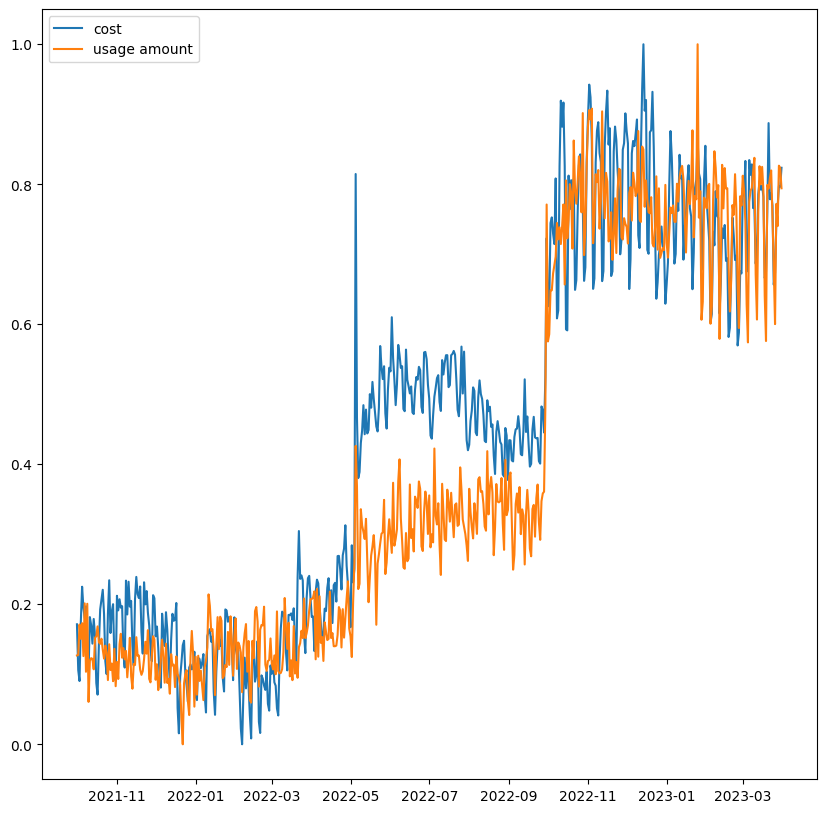

In [60]:
# plotting again the cost per day

plt.figure(figsize = (10,10))

viz_df = daily_df.reset_index()

plt.plot(viz_df['usage_date'], viz_df['amortized_cost'], label='cost')
plt.plot(viz_df['usage_date'], viz_df['usage_amount'], label = 'usage amount')

plt.legend()
plt.show()

As seen above, we can take a **completely different conclusion than before**. In fact, there seems to be a generalized upwards trend from 2021 onwards and this might be due to the fact that we were in COVID years until end of 2022 where life tended to become normal like before and, so, maybe costs and usage rose. Despite these spikes in may 2022 and October 2022 (these can be outliers), we see staber floatings and upwards trend from  6 to 6 months. This info may be very useful for our modelling and indicates very well what should be our lag number (so having a 6 months lag span). *There seems to be a very good correlation between the cost and the usage as well!*
**To further compare, we'll do the same graphs for weekly data and for monthly data and decide later on the best time granularity to use.**

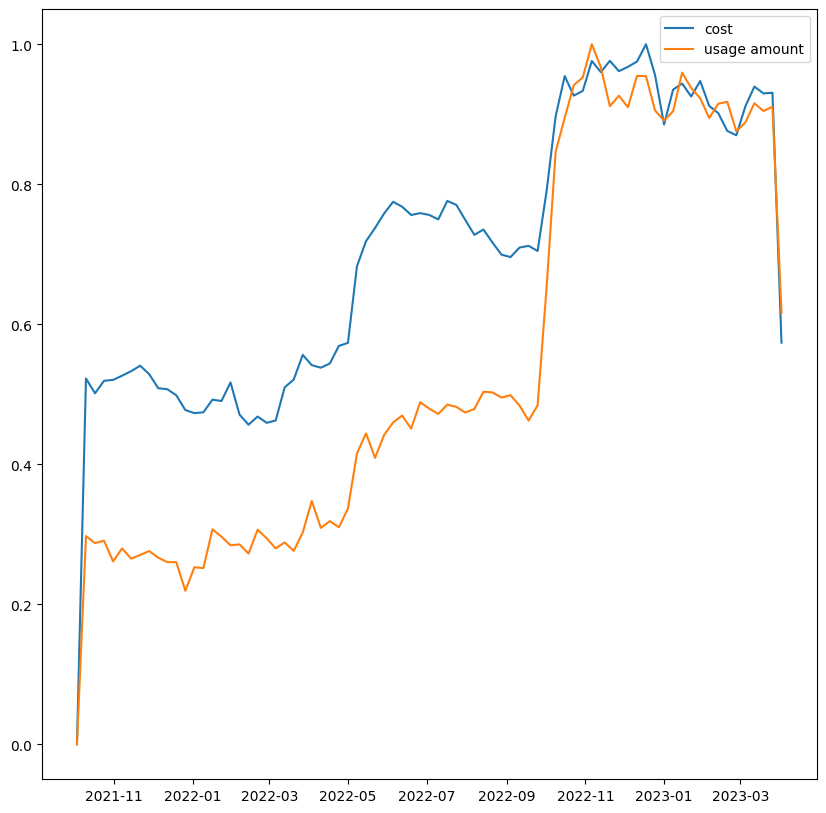

In [61]:
# plotting the cost per week

week_df = date_granularity(normalized_df, 'W')
viz_df = week_df.reset_index()

plt.figure(figsize = (10,10))
plt.plot(viz_df['usage_date'], viz_df['amortized_cost'], label='cost')
plt.plot(viz_df['usage_date'], viz_df['usage_amount'], label = 'usage amount')

plt.legend()
plt.show()

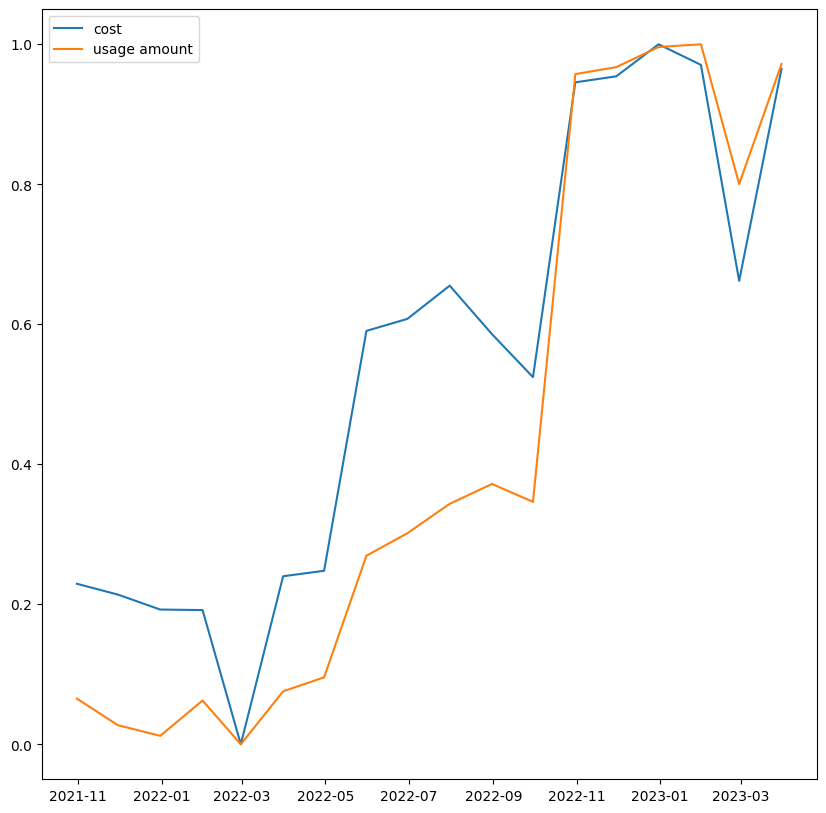

In [62]:
# plotting the cost per month

month_df = date_granularity(normalized_df, 'M')
viz_df = month_df.reset_index()

plt.figure(figsize = (10,10))
plt.plot(viz_df['usage_date'], viz_df['amortized_cost'], label='cost')
plt.plot(viz_df['usage_date'], viz_df['usage_amount'], label = 'usage amount')

plt.legend()
plt.show()

Analysing monthly graph, we don't see much findings in terms of patterns like we saw with daily data. For weekly, we see more interesting conclusions with a better pattern but still a bit weird, specially in the final weeks of our dataset.

**Thus, we will keep on using daily data.**

###Correlation between Variables and Features Removal

Let's assess for a Pearson's correlation test (using an heatmap) and check for redudant variables or other possible relationships between them.
Since, we have lots of variables, we are only going to assess the **relationship between the continuous variables and product_tag**, since these are requirement for our independent variables.

<Axes: >

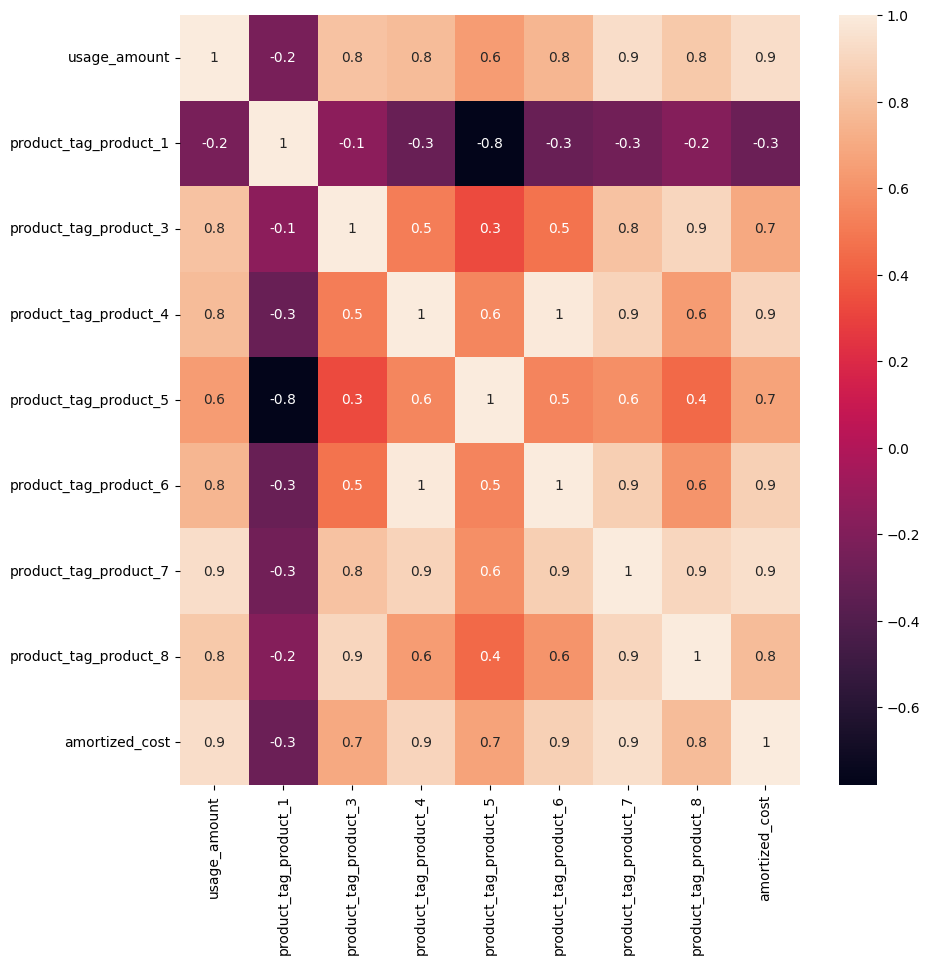

In [63]:
# since we have many variables, lets remove the variable "operation..." for this part only
corr = daily_df[[c for c in daily_df.columns if c.startswith('product_tag') or c in ['usage_amount', 'amortized_cost']]].corr()
figure = plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt = '.1g')

As expected, the paradigm changes now. We see much more correlation when we resample the data and there are even variables pratically all correlated: this is the case for usage_amount and amortized_cost (proven in the graph above) as well as the product_tag_4 and product_tag_6, with almost 1 in Pearson correlation.
*Almost all seem to have a positive mid to strong connection with the dependent variable, with exception of product_tag_product_1 which seems to be negatively correlated*.




**Thus, we shall remove redundant variables with correlation higher than 0.9 to the target variable and those who have null values (means that its normalized values are always 0 or close) and we'll do this for the whole dataset (not just for these features).**

In [64]:
corr_matrix = daily_df.corr()
corr_matrix

,month,quarter,weekday,usage_amount,line_item_type_other,line_item_type_usage,product_code_awscloudtrail,product_code_awselb,product_code_awslambda,product_code_awsqueueservice,...,environment_tag_uat,environment_tag_unknown,product_tag_product_1,product_tag_product_3,product_tag_product_4,product_tag_product_5,product_tag_product_6,product_tag_product_7,product_tag_product_8,amortized_cost
month,1.000000,0.978564,0.348365,0.545379,0.416412,0.557048,NaN,0.557241,0.568488,0.533193,...,0.599507,0.536016,-0.243336,0.099087,0.592420,0.611321,0.610862,0.506591,0.272757,0.616532
quarter,0.978564,1.000000,0.291815,0.479645,0.334533,0.465966,NaN,0.484031,0.510260,0.446453,...,0.518101,0.455920,-0.214101,-0.007984,0.511377,0.603103,0.533833,0.409450,0.160902,0.545674
weekday,0.348365,0.291815,1.000000,0.525463,0.533311,0.615512,NaN,0.564378,0.498543,0.608270,...,0.603195,0.583758,-0.179637,0.448413,0.605521,0.330985,0.580946,0.596709,0.506980,0.509622
usage_amount,0.545379,0.479645,0.525463,1.000000,0.616592,0.907890,NaN,0.657511,0.584464,0.901538,...,0.798768,0.972112,-0.233666,0.807127,0.778053,0.644340,0.753815,0.934507,0.839698,0.936611
line_item_type_other,0.416412,0.334533,0.533311,0.616592,1.000000,0.865161,NaN,0.948489,0.915405,0.870395,...,0.940254,0.664550,-0.288202,0.443154,0.937559,0.395164,0.949005,0.776174,0.546363,0.754225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
product_tag_product_5,0.611321,0.603103,0.330985,0.644340,0.395164,0.593852,NaN,0.487505,0.429598,0.587786,...,0.564815,0.623140,-0.779708,0.326297,0.553694,1.000000,0.545538,0.588937,0.441747,0.667459
product_tag_product_6,0.610862,0.533833,0.580946,0.753815,0.949005,0.941837,NaN,0.979013,0.901969,0.940807,...,0.994455,0.788187,-0.302955,0.475971,0.992726,0.545538,1.000000,0.861316,0.604810,0.873811
product_tag_product_7,0.506591,0.409450,0.596709,0.934507,0.776174,0.976832,NaN,0.787928,0.703557,0.961997,...,0.900410,0.963504,-0.263164,0.808103,0.884431,0.588937,0.861316,1.000000,0.899026,0.941088
product_tag_product_8,0.272757,0.160902,0.506980,0.839698,0.546363,0.813178,NaN,0.516802,0.460112,0.789727,...,0.667197,0.865463,-0.187430,0.901864,0.643677,0.441747,0.604810,0.899026,1.000000,0.780468


In [65]:
# fill the ones all null so they are removed
corr_matrix = daily_df.corr().abs().fillna(0.99)

keep_corr = corr_matrix[corr_matrix <= 0.9]
redundant_corr = corr_matrix[corr_matrix > 0.9]
redundant_corr

,month,quarter,weekday,usage_amount,line_item_type_other,line_item_type_usage,product_code_awscloudtrail,product_code_awselb,product_code_awslambda,product_code_awsqueueservice,...,environment_tag_uat,environment_tag_unknown,product_tag_product_1,product_tag_product_3,product_tag_product_4,product_tag_product_5,product_tag_product_6,product_tag_product_7,product_tag_product_8,amortized_cost
month,1.000000,0.978564,NaN,NaN,NaN,NaN,0.99,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quarter,0.978564,1.000000,NaN,NaN,NaN,NaN,0.99,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday,NaN,NaN,1.0,NaN,NaN,NaN,0.99,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage_amount,NaN,NaN,NaN,1.000000,NaN,0.907890,0.99,NaN,NaN,0.901538,...,NaN,0.972112,NaN,NaN,NaN,NaN,NaN,0.934507,NaN,0.936611
line_item_type_other,NaN,NaN,NaN,NaN,1.000000,NaN,0.99,0.948489,0.915405,NaN,...,0.940254,NaN,NaN,NaN,0.937559,NaN,0.949005,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
product_tag_product_5,NaN,NaN,NaN,NaN,NaN,NaN,0.99,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
product_tag_product_6,NaN,NaN,NaN,NaN,0.949005,0.941837,0.99,0.979013,0.901969,0.940807,...,0.994455,NaN,NaN,NaN,0.992726,NaN,1.000000,NaN,NaN,NaN
product_tag_product_7,NaN,NaN,NaN,0.934507,NaN,0.976832,0.99,NaN,NaN,0.961997,...,0.900410,0.963504,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.941088
product_tag_product_8,NaN,NaN,NaN,NaN,NaN,NaN,0.99,NaN,NaN,NaN,...,NaN,NaN,NaN,0.901864,NaN,NaN,NaN,NaN,1.0,NaN


In [66]:
cols_to_keep = list(keep_corr[keep_corr.index == 'amortized_cost'].dropna(axis=1).columns) + ['amortized_cost']
cols_to_keep

['month',
 'quarter',
 'weekday',
 'line_item_type_other',
 'product_code_awselb',
 'product_code_awslambda',
 'product_code_amazondynamodb',
 'product_code_amazones',
 'product_code_amazonmsk',
 'product_code_amazonrds',
 'product_code_amazonvpc',
 'product_code_other',
 'operation_clientvpnconnections',
 'operation_createcachecluster',
 'operation_createdbinstance',
 'operation_createsnapshot',
 'operation_createvolume',
 'operation_crossregion',
 'operation_esdomain',
 'operation_head',
 'operation_invoke',
 'operation_list',
 'operation_listdomains',
 'operation_listsubscriptions',
 'operation_loadbalancing',
 'operation_none',
 'operation_not_applicable',
 'operation_options',
 'operation_post',
 'operation_payperrequestthroughput',
 'operation_postobject',
 'operation_putlogevents',
 'operation_putobjectforrepl',
 'operation_readbucketmetrics',
 'operation_readbucketpolicystatus',
 'operation_readnotificationprops',
 'operation_send',
 'environment_tag_default',
 'environment_tag

In [67]:
len(cols_to_keep)

47

To conclude, we will remove a lot of variables now because most of them were extremely high correlated with the costs variable, making them redundant and could potentially hurt the model or at least don't provide useful information.
**The usage_amount was one of those variables given its pretty strong positive correlation. Also, the product tag of product 7 was proven to be redundant too.**


We'll keep 47 columns in total before getting to more features to be created (lag variables) and we proceed with further feature importance and removal, having into account Auto Regressive models (i.e. with the help of lagged values for the target variable to predict its self values).

In [68]:
daily_df = daily_df[cols_to_keep]
daily_df

,month,quarter,weekday,line_item_type_other,product_code_awselb,product_code_awslambda,product_code_amazondynamodb,product_code_amazones,product_code_amazonmsk,product_code_amazonrds,...,environment_tag_default,environment_tag_staging,environment_tag_uat,product_tag_product_1,product_tag_product_3,product_tag_product_4,product_tag_product_5,product_tag_product_6,product_tag_product_8,amortized_cost
usage_date,,,,,,,,,,,,,,,,,,,,,
2021-10-01,0.118464,0.144789,0.095613,0.000000,0.00,0.000000,0.125,0.0,0.142857,0.04,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.533724,0.000000,0.000000,0.171398
2021-10-02,0.119115,0.145585,0.120173,0.000000,0.00,0.000000,0.125,0.0,0.142857,0.04,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.536657,0.000000,0.000000,0.105886
2021-10-03,0.119115,0.145585,0.144208,0.000000,0.00,0.000000,0.125,0.0,0.142857,0.04,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.536657,0.000000,0.000000,0.090339
2021-10-04,0.120417,0.147176,0.000000,0.000000,0.00,0.000000,0.125,0.0,0.142857,0.04,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.542522,0.000000,0.000000,0.175615
2021-10-05,0.120417,0.147176,0.024297,0.000000,0.00,0.000000,0.125,0.0,0.142857,0.04,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.542522,0.000000,0.000000,0.225047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,0.189050,0.000000,0.000000,0.705882,0.75,0.571429,0.625,0.4,0.571429,0.76,...,0.0,0.0,0.884615,0.0,0.965300,0.953237,0.580645,0.948087,0.942308,0.746242
2023-03-28,0.186591,0.000000,0.169425,0.705882,0.75,0.571429,0.625,0.4,0.571429,0.76,...,0.0,0.0,0.884615,0.0,0.949527,0.949640,0.577713,0.939891,0.923077,0.768616
2023-03-29,0.187459,0.000000,0.340426,0.705882,0.75,0.571429,0.625,0.4,0.571429,0.76,...,0.0,0.0,0.897436,0.0,0.958991,0.956835,0.612903,0.909836,0.923077,0.797551


# Time Series Forecast Modelling

Now, its time for the modelling part given the data and the treatments we already have.

For the purpose of being a MultiVariate Time Series Regression model, I decided to explore one simpler ML model and a DL model:
- Light GBM model
- LSTM model

##LightGBM Model

LightGBM (LGBM) is a gradient boosting framework that is known for its efficiency, speed, and accuracy in handling large-scale datasets.
It is capable of capturing complex nonlinear relationships between the independent and target variables. For feature importance is also really helpful and we can set a ranking like we'll see more ahead.

**A test using an autoregressive lagged model (i.e. using the own target lagged variable to predict the future values of itself) will be made and, finally, a non AR model will be assessed as well to remove any possible bias and try to include as most as possible the influence of "Product_tag" and other columns so we can reach conclusions.**



###Autoregressive Model

In [69]:
def time_delay_embedding(series, n_lags, horizon):

  if series.name is None:
      name = 'Series'
  else:
      name = series.name

  n_lags_iter = list(range(n_lags, -horizon, -1))

  df_list = [series.shift(i) for i in n_lags_iter]
  df = pd.concat(df_list, axis=1).dropna()

  df.columns = [f'{name}(t-{j - 1})'
                if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                for j in n_lags_iter]

  df.columns = [re.sub('t-0', 't', x) for x in df.columns]

  return df

In [70]:
def error_metrics(Y_ts, predictions):

  # Mean Squared Error (MSE)
  mse = mean_squared_error(Y_ts, predictions)

  # Root Mean Squared Error (RMSE)
  rmse = np.sqrt(mse)

  # Mean Absolute Error (MAE)
  mae = mean_absolute_error(Y_ts, predictions)

  # Mean Absolute Percentage Error (MAPE)
  mape = mean_absolute_percentage_error(Y_ts, predictions)

  print("Mean Squared Error (MSE):", mse)
  print("Root Mean Squared Error (RMSE):", rmse)
  print("Mean Absolute Error (MAE):", mae)
  print("Mean Absolute Percentage Error (MAPE):", mape)

In [71]:
# horizon will be 6 months * 30 days = 180 days
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.multioutput import MultiOutputRegressor

from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

def LGBM_model(df, n_lags, target_var='amortized_cost'):

  print('Nr of lags choosen:', n_lags, '\n')
  list_cols = []
  for col in df:
      col_df = time_delay_embedding(df[col], n_lags=n_lags, horizon=180)
      list_cols.append(col_df)

  # concatenating all variables and drop nulls
  new_df = pd.concat(list_cols, axis=1).dropna()

  # defining target (Y) and explanatory variables (X)
  predictor_variables = new_df.columns.str.contains('\(t\-')
  target_variables = new_df.columns.str.contains(f'{target_var}\(t\+')

  X = new_df.iloc[:, predictor_variables]
  Y = new_df.iloc[:, target_variables]

  # train/test split with 0.7/0.3 standard split
  X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False)

  # fitting a LGBM model without feature engineering
  model_wo_fe = MultiOutputRegressor(LGBMRegressor(random_state=0, n_estimators=100))
  model_wo_fe.fit(X_tr, Y_tr)

  # getting forecasts for the test set
  predictions = model_wo_fe.predict(X_ts)

  # computing all the error metrics
  error_metrics(Y_ts, predictions)

  print('------------------------', '\n')

In [72]:
## see the minimum MAPE to choose the number of lags (choose between 1 day and 6 months to cover many possibilities)

target_var = 'amortized_cost'

lags = [1,7,14,30,60,90,180]

for lag in lags:
  LGBM_model(daily_df, lag)


Nr of lags choosen: 1 

Mean Squared Error (MSE): 0.13646707105373124
Root Mean Squared Error (RMSE): 0.36941449762256384
Mean Absolute Error (MAE): 0.3399056254315349
Mean Absolute Percentage Error (MAPE): 0.48248683588565816
------------------------ 

Nr of lags choosen: 7 

Mean Squared Error (MSE): 0.0671404094699731
Root Mean Squared Error (RMSE): 0.25911466471424016
Mean Absolute Error (MAE): 0.18767643832727515
Mean Absolute Percentage Error (MAPE): 0.2523790685555252
------------------------ 

Nr of lags choosen: 14 

Mean Squared Error (MSE): 0.06381043501191888
Root Mean Squared Error (RMSE): 0.25260727426564517
Mean Absolute Error (MAE): 0.18075700077130483
Mean Absolute Percentage Error (MAPE): 0.24315603378922487
------------------------ 

Nr of lags choosen: 30 

Mean Squared Error (MSE): 0.04919435536630997
Root Mean Squared Error (RMSE): 0.22179800577622416
Mean Absolute Error (MAE): 0.15728738596026984
Mean Absolute Percentage Error (MAPE): 0.2130434044111211
---------

Therefore, upon these results, the best number of lags to chose seems to be 180 days, because its the one that minimizes the average percentage difference between the predicted and actual values (MAPE) and the Mean Abolute Error (MAE).

This value is in line on the graphs we saw above, that we could better capture a whole 6 months before trend to predict the next 6 months. The issues that we can have is that, first, we exploded many variables, as we create more lagged features and, second, we might be overfitting our model.**Therefore, we'll choose the 30 days lagged solution, which seem the most viable given the possible overfiting and overdimensionality issues.**

Next, let's see the most important features (top 100) and check if the autoregressive target  and other time variables had a big impact on the model and, overshadowed the other independent variables.

In [73]:
## choosing the optimal nr of lag = 30
n_lags=30
target_var = 'amortized_cost'

list_cols = []
for col in daily_df:
    col_df = time_delay_embedding(daily_df[col], n_lags=n_lags, horizon=180)
    list_cols.append(col_df)

# concatenating all variables and drop nulls
new_df = pd.concat(list_cols, axis=1).dropna()

# defining target (Y) and explanatory variables (X)
predictor_variables = new_df.columns.str.contains('\(t\-')
target_variables = new_df.columns.str.contains(f'{target_var}\(t\+')

X = new_df.iloc[:, predictor_variables]
Y = new_df.iloc[:, target_variables]

# train/test split with 70/30 standard split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False)

# fitting a LGBM model without feature engineering
model_wo_fe = MultiOutputRegressor(LGBMRegressor(random_state=0, n_estimators=100))
model_wo_fe.fit(X_tr, Y_tr)

# getting forecasts for the test set
predictions = model_wo_fe.predict(X_ts)

# computing all the error metrics
error_metrics(Y_ts, predictions)

Mean Squared Error (MSE): 0.04919435536630997
Root Mean Squared Error (RMSE): 0.22179800577622416
Mean Absolute Error (MAE): 0.15728738596026984
Mean Absolute Percentage Error (MAPE): 0.2130434044111211


In [74]:
new_df.shape

(338, 9870)

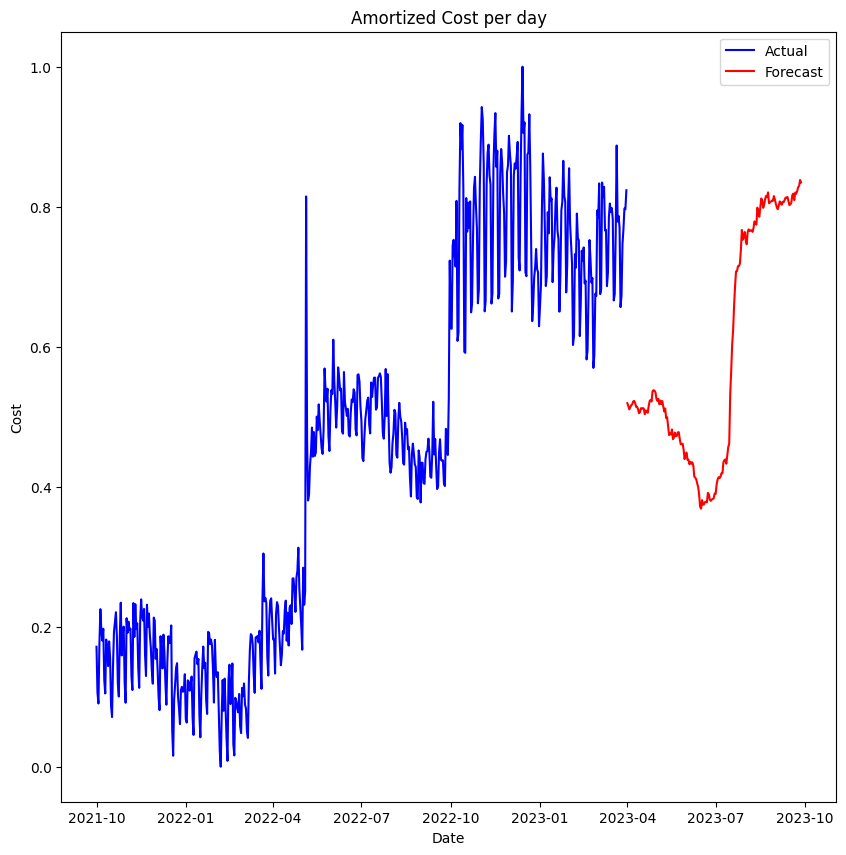

In [75]:
# plot actual + forecast values
def plot_forecast(predictions, df_initial):
  forecast_values = np.mean(predictions, axis=0) # do average of predictions
  forecast_dates = pd.date_range(start=df_initial.index[-1] + pd.DateOffset(1), periods=len(predictions[1]), freq='D')

  figure = plt.figure(figsize=(10,10))
  plt.title('Amortized Cost per day')
  plt.plot(df_initial.index, df_initial['amortized_cost'], color='blue', label = 'Actual')
  plt.plot(forecast_dates, forecast_values, color='red', label='Forecast')
  plt.xlabel('Date')
  plt.ylabel('Cost')
  plt.legend()
  return plt.show()

plot_forecast(predictions, daily_df)

Even though we see a big drop right in the first observation (like it happened twice in the past), we see a similar pattern of forecasted normalized values based mostly on more recent months.

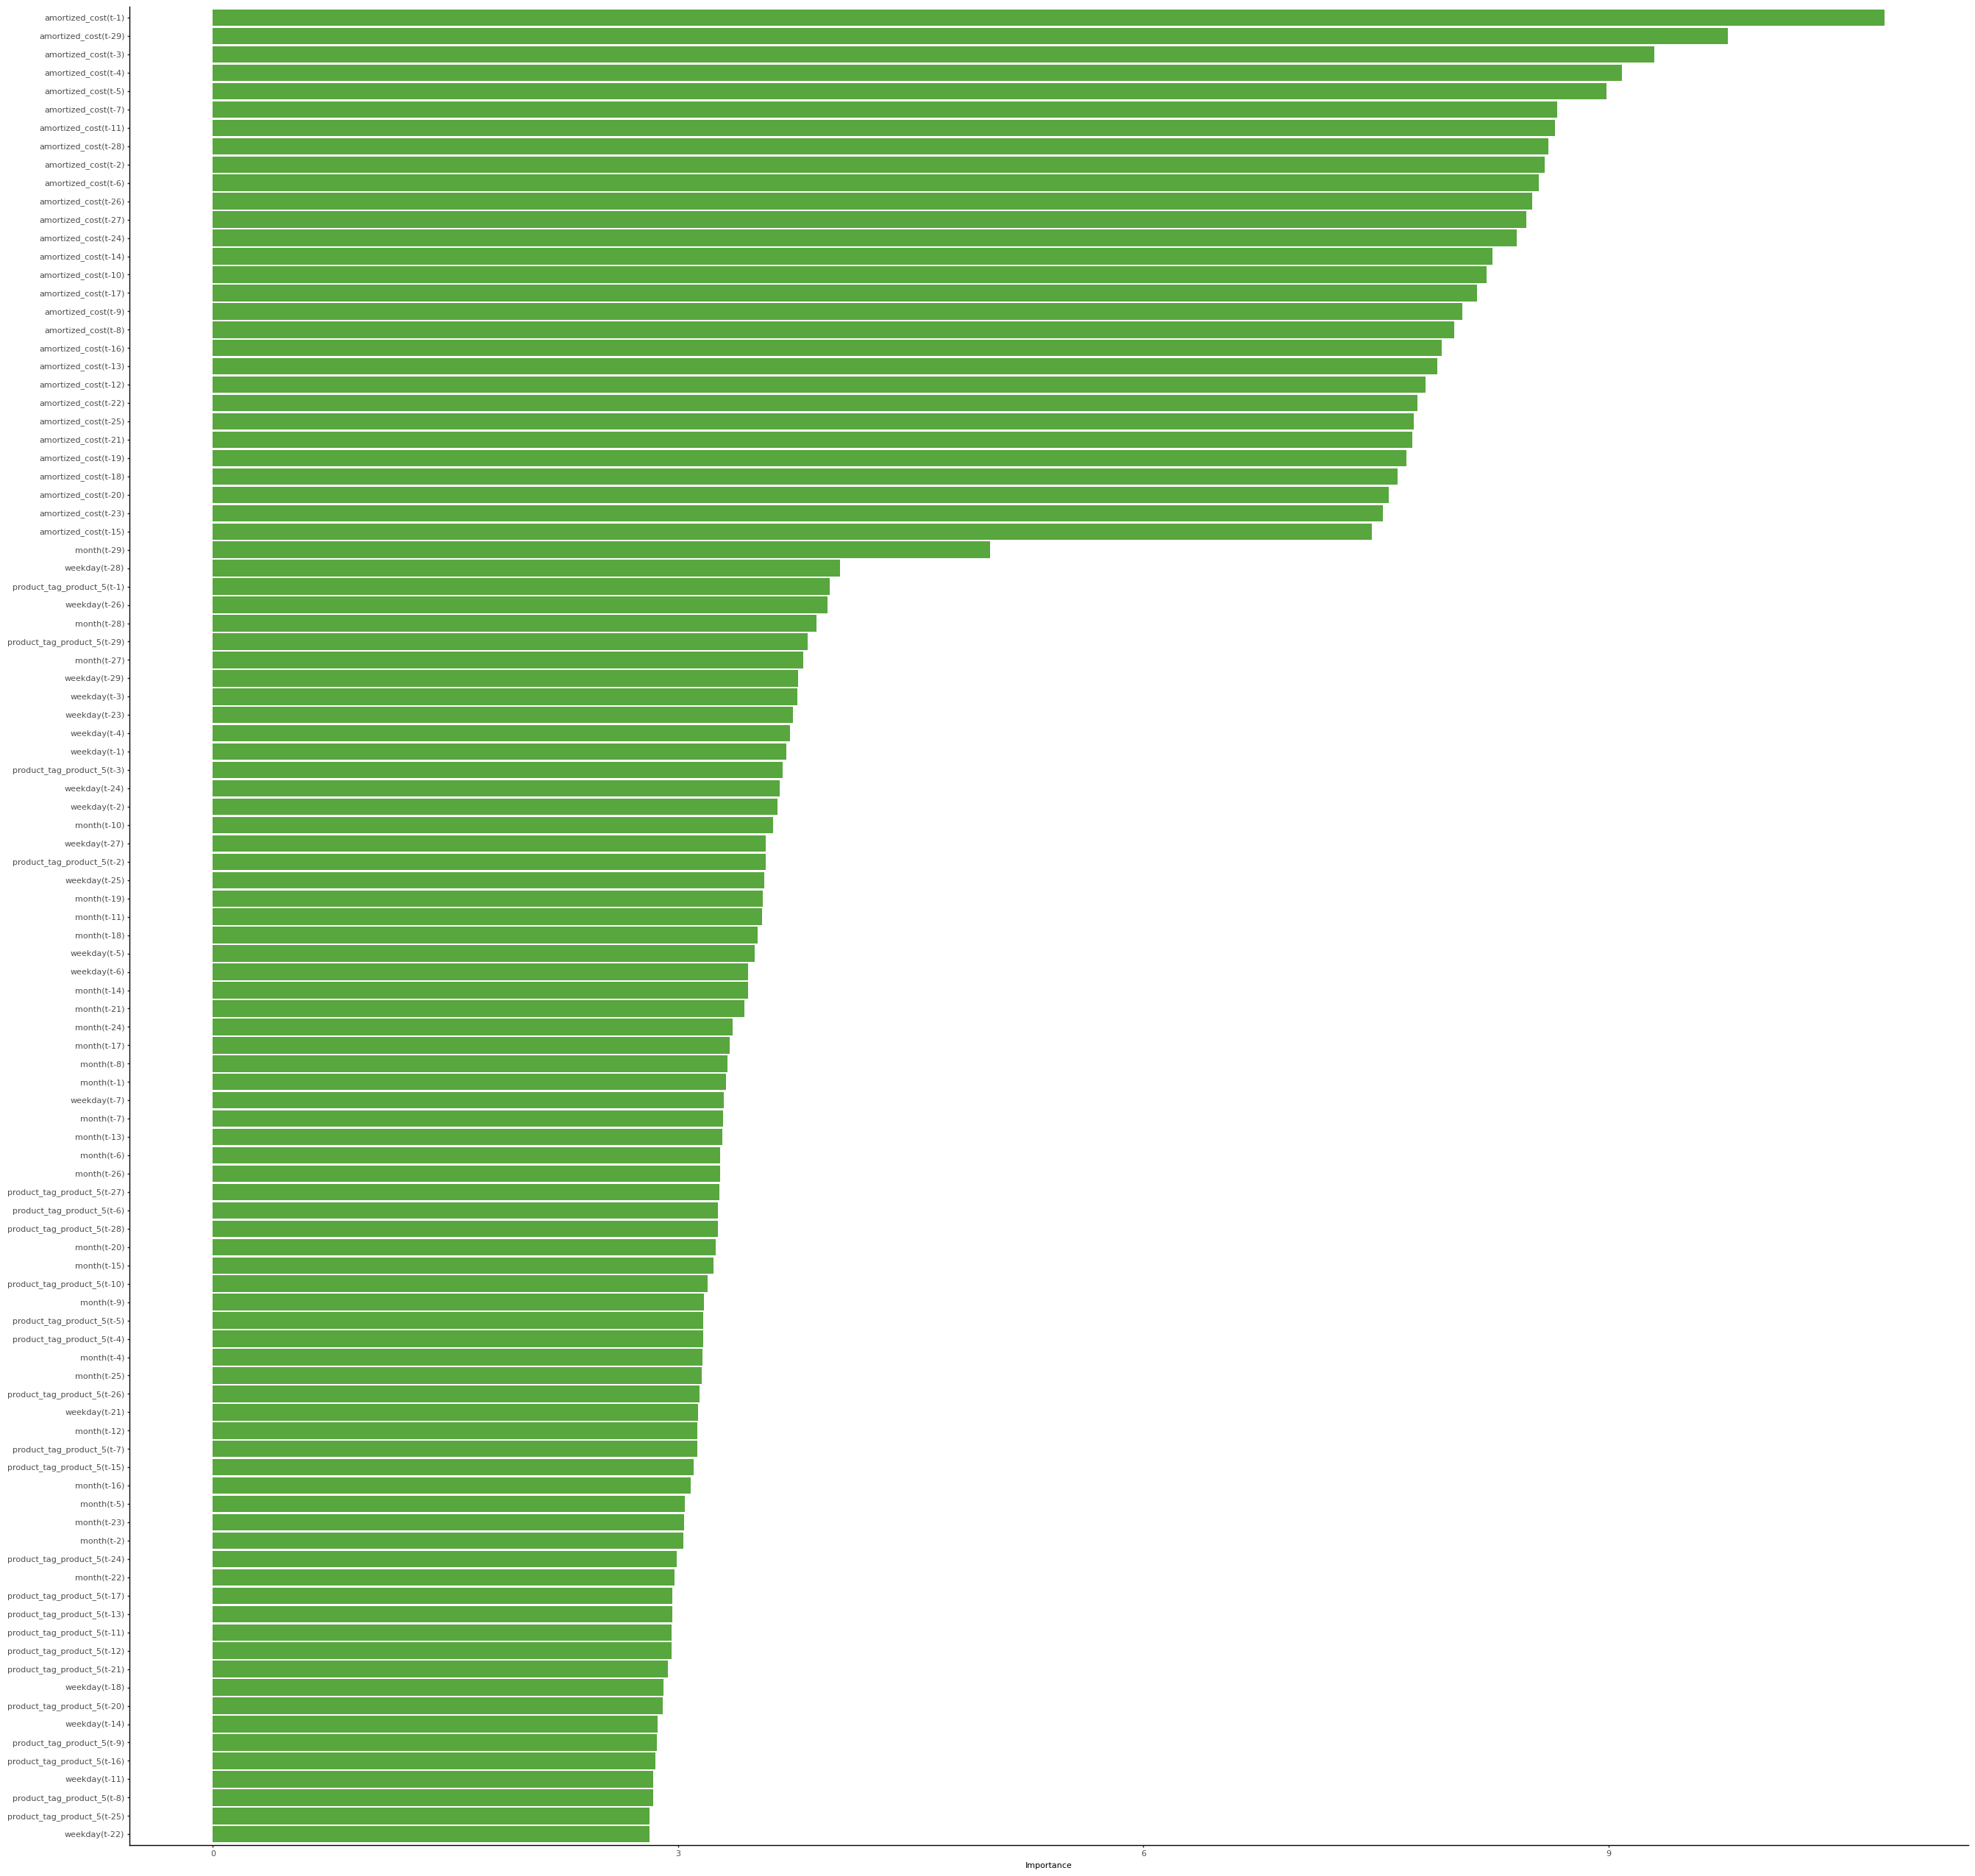

<ggplot: (8741490049487)>

In [76]:
# getting the importance of each feature - top 100

avg_imp = pd.DataFrame([x.feature_importances_
                        for x in model_wo_fe.estimators_]).mean()

# getting the top 100 features
n_top_features = 100

importance_scores = pd.Series(dict(zip(X_tr.columns, avg_imp)))
top_features = importance_scores.sort_values(ascending=False)[:n_top_features]
top_features_nm = top_features.index

# subsetting training and testing sets by those features
X_tr_top = X_tr[top_features_nm]
X_ts_top = X_ts[top_features_nm]

# re-fitting the lgbm model
model_top_features = MultiOutputRegressor(LGBMRegressor(random_state=0, n_estimators=100))
model_top_features.fit(X_tr_top, Y_tr)

# getting forecasts for the test set
preds_top_feats = model_top_features.predict(X_ts_top)


# plot top 100 features


imp_df = importance_scores.sort_values(ascending=True)[-n_top_features:].reset_index()
imp_df.columns = ['Feature', 'Importance']
imp_df['Feature'] = pd.Categorical(imp_df['Feature'], categories=imp_df['Feature'])


plot = ggplot(imp_df, aes(x='Feature', y='Importance')) + \
       geom_bar(fill='#58a63e', stat='identity', position='dodge') + \
       theme_classic(
           base_size=10) + \
       theme(
           plot_margin=.25,
           axis_text=element_text(size=8),
           axis_text_x=element_text(size=8),
           axis_title=element_text(size=8),
           legend_text=element_text(size=8),
           legend_title=element_text(size=8),
           legend_position='top') + \
       xlab('') + \
       ylab('Importance') + coord_flip() + \
       theme(figure_size=(50, 50))

plot

As seen, almost all important features include the own variable (with several T-X lags) and the effect of seasonality as well with the weekday and months lagged.
The only most relevant variable here for our problem is the importance of the **Product Tag - Product 5**.

**In order to remove these bias and try to assess other important variables to forecast (even though it might produce a worse model), we'll do the same modelling but now removing the autoregressive target variable as well as the date columns.**

###Non AR Model

In [77]:
daily_df_new = daily_df.copy()
daily_df_new = daily_df_new.drop(['month', 'quarter', 'weekday'], axis=1)

In [78]:
## choosing the optimal nr of lag = 30
from sklearn.metrics import *
n_lags=30
target_var = 'amortized_cost'

list_cols = []
for col in daily_df_new:
    col_df = time_delay_embedding(daily_df_new[col], n_lags=n_lags, horizon=180)
    list_cols.append(col_df)

# concatenating all variables and drop nulls
new_df = pd.concat(list_cols, axis=1).dropna()

# defining target (Y) and explanatory variables (X)
# explanatory variables now shouldnt include the target

predictor_variables = (new_df.columns.str.contains('\(t\-')) & (~new_df.columns.str.contains(target_var))
target_variables = new_df.columns.str.contains(f'{target_var}\(t\+')

X = new_df.iloc[:, predictor_variables]
Y = new_df.iloc[:, target_variables]

# train/test split with 70/30 standard split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False)

# fitting a LGBM model without feature engineering
model_wo_fe = MultiOutputRegressor(LGBMRegressor(random_state=0, n_estimators=100))
model_wo_fe.fit(X_tr, Y_tr)

# getting forecasts for the test set
predictions = model_wo_fe.predict(X_ts)

# computing all the error metrics
error_metrics(Y_ts, predictions)

Mean Squared Error (MSE): 0.05044938063691881
Root Mean Squared Error (RMSE): 0.2246093957004444
Mean Absolute Error (MAE): 0.15918383316730308
Mean Absolute Percentage Error (MAPE): 0.21452242549160666


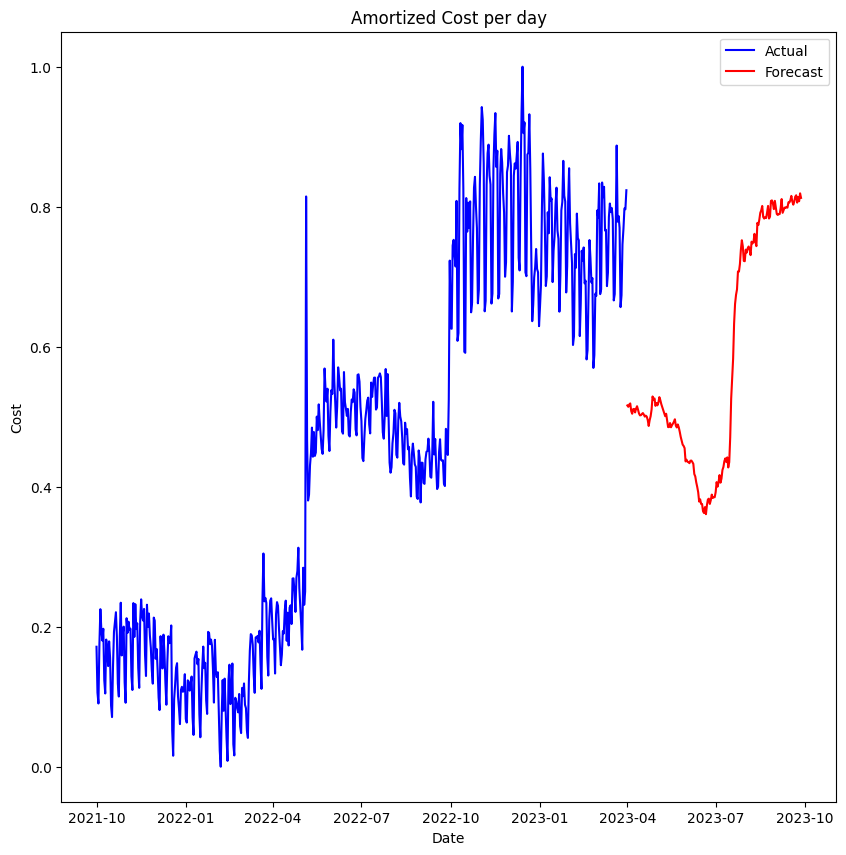

In [79]:
# plot actual + forecast values

plot_forecast(predictions, daily_df_new)

The same pattern applies here, so we can conclude that without the date and the own cost effect, **we have variables in our dataset good enough to predict the future costs!**

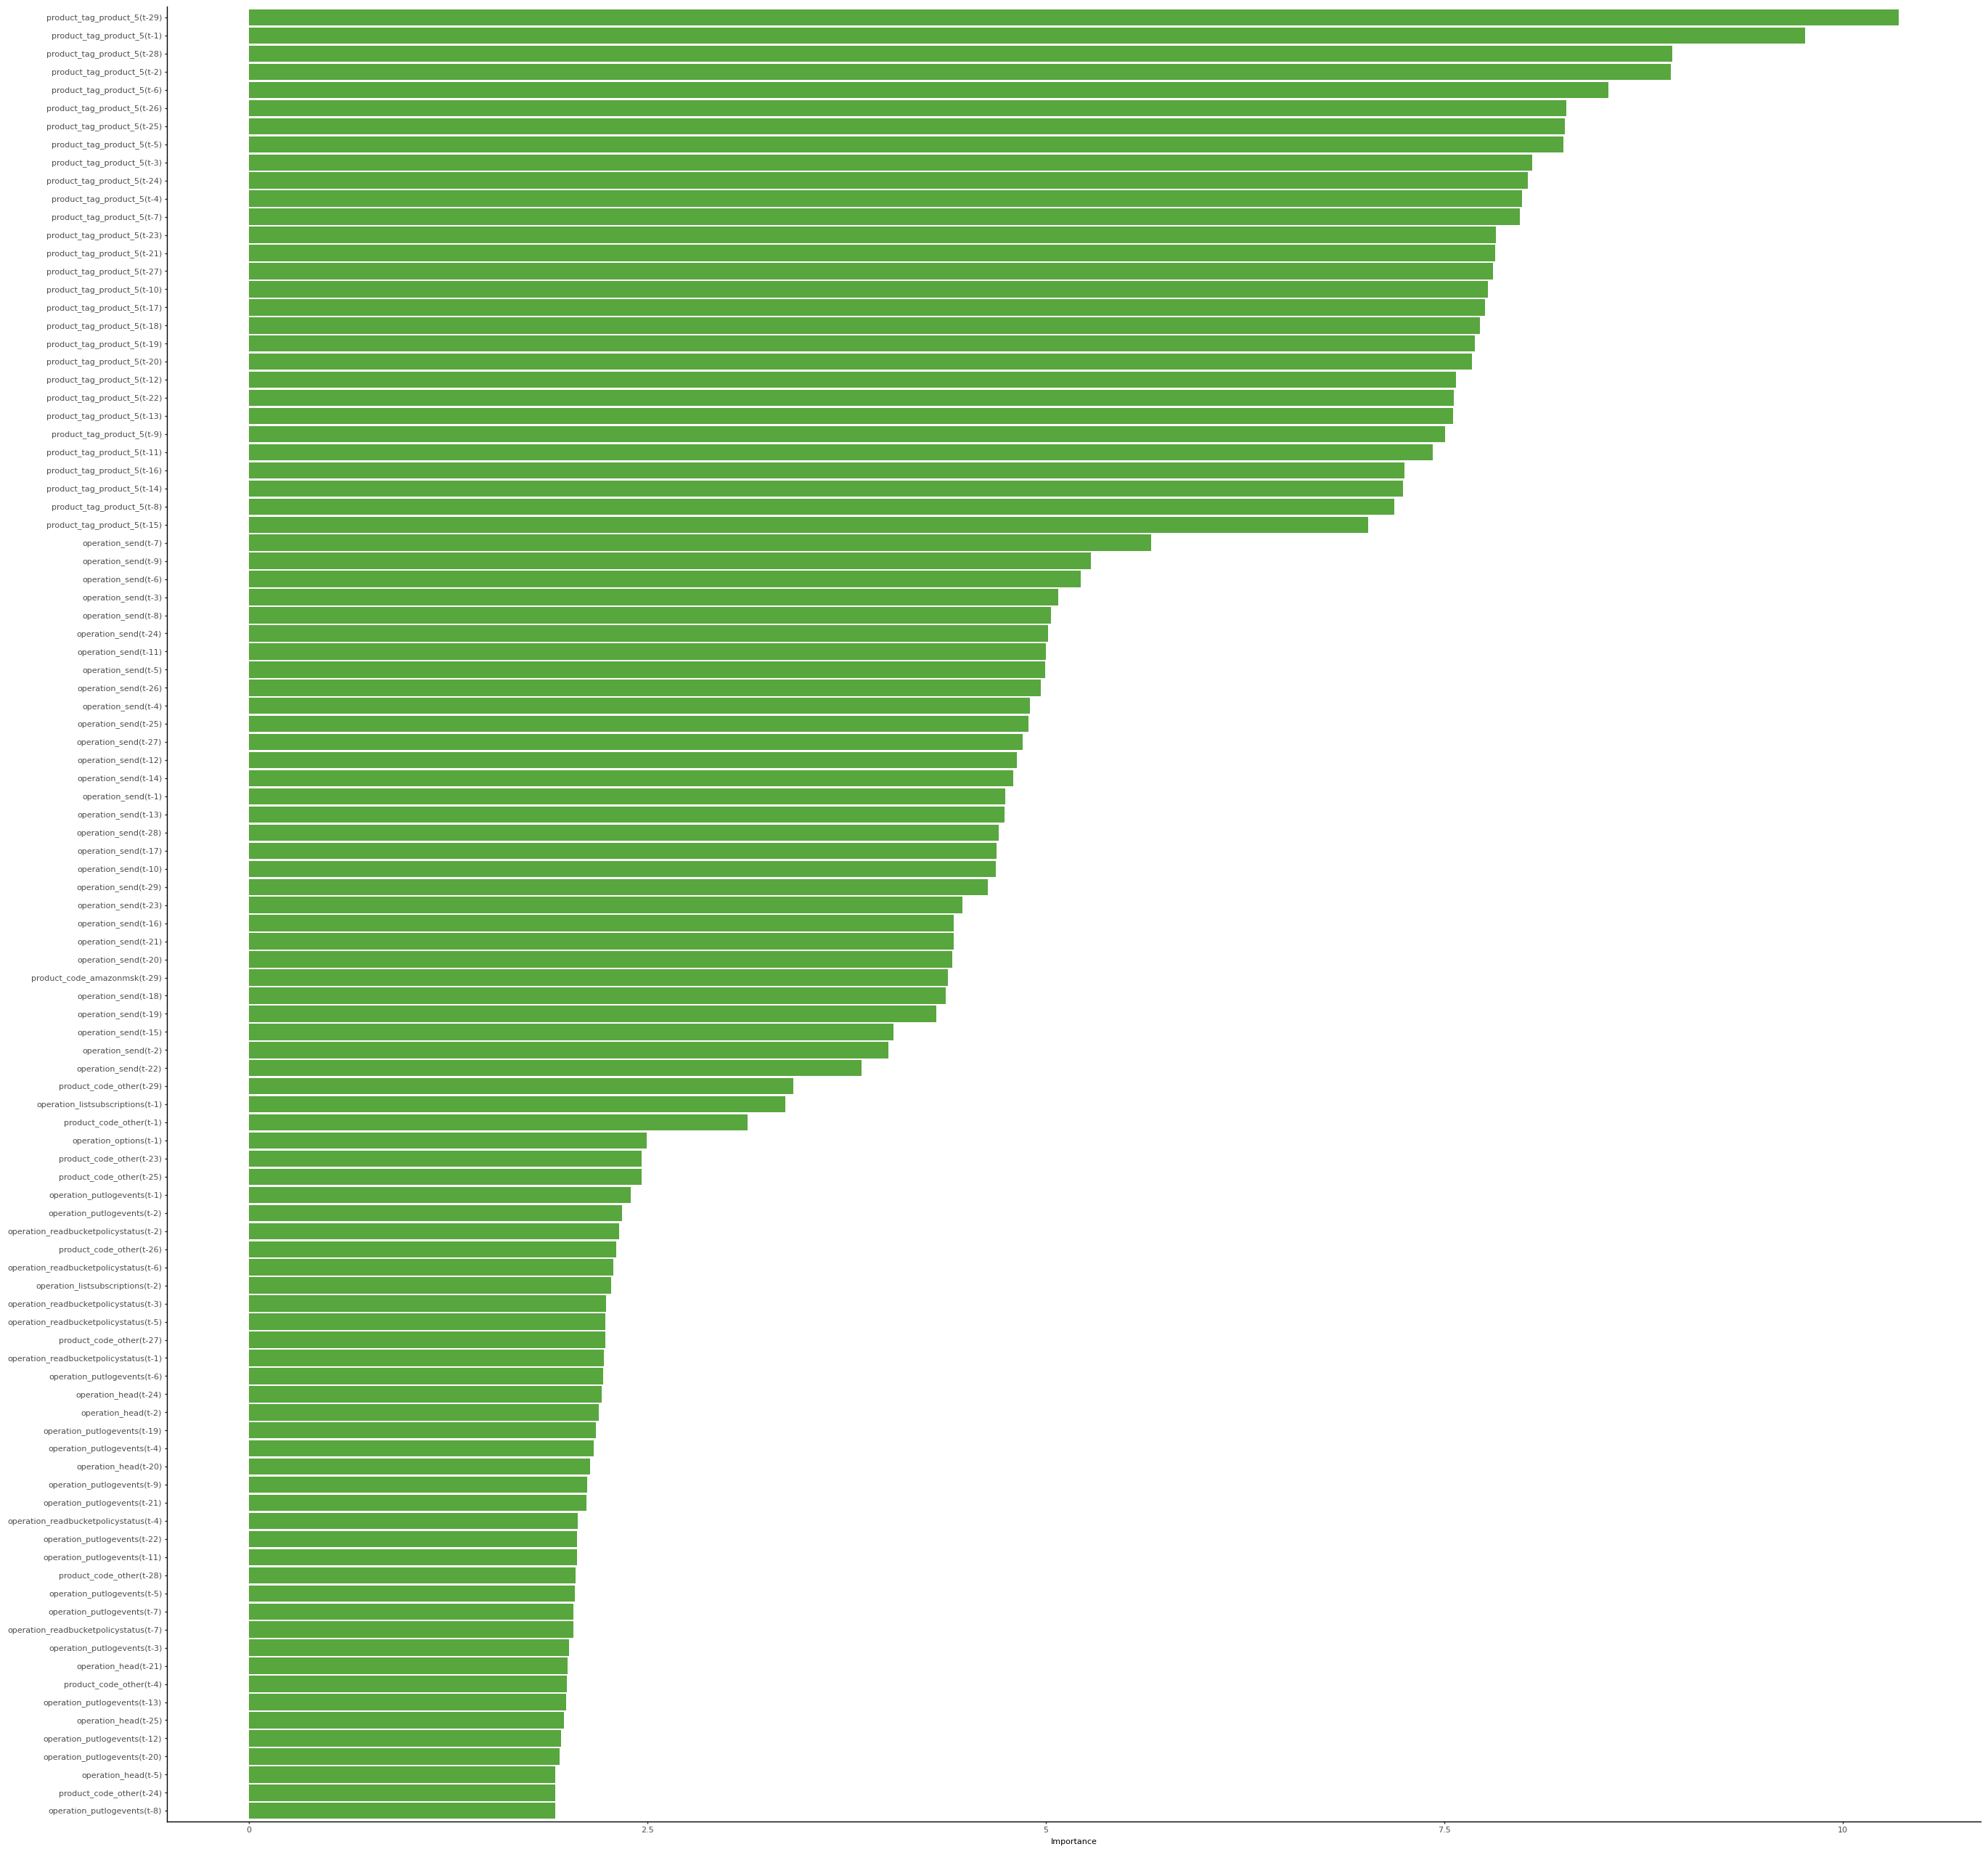

<ggplot: (8741490140875)>

In [80]:
# getting the importance of each feature - top 100

avg_imp = pd.DataFrame([x.feature_importances_
                        for x in model_wo_fe.estimators_]).mean()

n_top_features = 100

importance_scores = pd.Series(dict(zip(X_tr.columns, avg_imp)))
top_features = importance_scores.sort_values(ascending=False)[:n_top_features]
top_features_nm = top_features.index

# subsetting training and testing sets by those features
X_tr_top = X_tr[top_features_nm]
X_ts_top = X_ts[top_features_nm]

# re-fitting the lgbm model
model_top_features = MultiOutputRegressor(LGBMRegressor(random_state=0, n_estimators=100))
model_top_features.fit(X_tr_top, Y_tr)

# getting forecasts for the test set
preds_top_feats = model_top_features.predict(X_ts_top)


# plot top 100 features

imp_df = importance_scores.sort_values(ascending=True)[-n_top_features:].reset_index()
imp_df.columns = ['Feature', 'Importance']
imp_df['Feature'] = pd.Categorical(imp_df['Feature'], categories=imp_df['Feature'])


plot = ggplot(imp_df, aes(x='Feature', y='Importance')) + \
       geom_bar(fill='#58a63e', stat='identity', position='dodge') + \
       theme_classic(
           base_size=10) + \
       theme(
           plot_margin=.25,
           axis_text=element_text(size=8),
           axis_text_x=element_text(size=8),
           axis_title=element_text(size=8),
           legend_text=element_text(size=8),
           legend_title=element_text(size=8),
           legend_position='top') + \
       xlab('') + \
       ylab('Importance') + coord_flip() + \
       theme(figure_size=(50, 50))

plot

Now there's more balance in terms of variable importance, not only in product, but also operations related. Different lags have influence as well and in mixed fashion.

Next, let's experiment a Deep Learning model to complement or possibly change this analysis and assess which model performs best, so that conclusions can be taken on a best accurate cost forecast and which were the main drivers of this spend increase, so that the company can focus mostly on some specific usages.

## LSTM Model

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) architecture that has several advantages for data modelling, including time series forecasting. It is very good to capture long term dependencies and that is the case for our dataset where we have to predict 6 months ahead based on previous 1 and half years (in days). It also deals well with noisy data. The issue that can arise here is that we can add more complexity than what is needed for the model (as the LGBM already performed quite well).

**We'll experiment using only a non AutoRegressive model to compare with the latter LGBM.**

In [81]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import itertools
import random

from sklearn.preprocessing import MinMaxScaler


def summary(df):
  desc = df.describe(include = 'all').T.rename(columns={"count": "count_non_nulls"})
  desc['count_nulls'] = df.shape[0]-desc['count_non_nulls']
  new_index_list = ['count_non_nulls', 'count_nulls']
  new_index=new_index_list + [c for c in desc.columns if c not in new_index_list]
  desc = desc.reindex(new_index, axis='columns')

  return desc

In [82]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import datetime as dt
import itertools
import random
import re

from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from plotnine import *
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
#import shap

In [83]:
def time_delay_embedding(series, n_lags, horizon):

  if series.name is None:
      name = 'Series'
  else:
      name = series.name

  n_lags_iter = list(range(n_lags, -horizon, -1))

  df_list = [series.shift(i) for i in n_lags_iter]
  df = pd.concat(df_list, axis=1).dropna()

  df.columns = [f'{name}(t-{j - 1})'
                if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                for j in n_lags_iter]

  df.columns = [re.sub('t-0', 't', x) for x in df.columns]

  return df

In [84]:
def error_metrics(Y_ts, predictions):

  # Mean Squared Error (MSE)
  mse = mean_squared_error(Y_ts, predictions)

  # Root Mean Squared Error (RMSE)
  rmse = np.sqrt(mse)

  # Mean Absolute Error (MAE)
  mae = mean_absolute_error(Y_ts, predictions)

  # Mean Absolute Percentage Error (MAPE)
  mape = mean_absolute_percentage_error(Y_ts, predictions)

  print("Mean Squared Error (MSE):", mse)
  print("Root Mean Squared Error (RMSE):", rmse)
  print("Mean Absolute Error (MAE):", mae)
  print("Mean Absolute Percentage Error (MAPE):", mape)

In [85]:
# import and see nb rows and columns of the input dataset
daily_df_new = pd.read_excel('/content/drive/MyDrive/daily_df_new.xlsx')
daily_df_new = daily_df_new.set_index('usage_date')
daily_df_new.shape

(547, 44)

###Non AR Model

Epoch 1/100
8/8 [==============================] - 3s 87ms/step - loss: 0.1099 - val_loss: 0.3143
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0591 - val_loss: 0.0423
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0321 - val_loss: 0.0272
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0276 - val_loss: 0.0385
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0247 - val_loss: 0.0424
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0241 - val_loss: 0.0443
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0234 - val_loss: 0.0368
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0231 - val_loss: 0.0373
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0229 - val_loss: 0.0385
Epoch 10/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0228 - val_loss: 0.0366
Epoch 11/100
8/8 [=

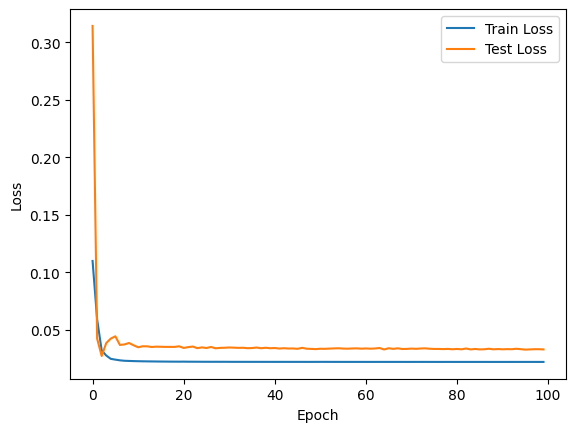

In [86]:
n_lags=30
target_var = 'amortized_cost'

list_cols = []
for col in daily_df_new:
    col_df = time_delay_embedding(daily_df_new[col], n_lags=n_lags, horizon=180)
    list_cols.append(col_df)

# concatenating all variables and drop nulls
new_df = pd.concat(list_cols, axis=1).dropna()

# defining target (Y) and explanatory variables (X)
# explanatory variables now shouldnt include the target

predictor_variables = (new_df.columns.str.contains('\(t\-')) & (~new_df.columns.str.contains(target_var))
target_variables = new_df.columns.str.contains(f'{target_var}\(t\+')

X = new_df.iloc[:, predictor_variables]
Y = new_df.iloc[:, target_variables]

# split the same way into train test
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=0)

n_features = X_tr.shape[1]
X_tr_reshaped = X_tr.to_numpy().reshape(-1, 1, n_features)
X_ts_reshaped = X_ts.to_numpy().reshape(-1, 1, n_features)

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_tr_reshaped, Y_tr, epochs=100, batch_size=32, validation_data=(X_ts_reshaped, Y_ts))

# Evaluate the model
train_loss = model.evaluate(X_tr_reshaped, Y_tr)
test_loss = model.evaluate(X_ts_reshaped, Y_ts)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# Make predictions
train_predictions = model.predict(X_tr_reshaped)
test_predictions = model.predict(X_ts_reshaped)

# Get the loss values from the history object
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Plot the loss values
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/20
8/8 [==============================] - 3s 79ms/step - loss: 0.1047 - val_loss: 0.2653
Epoch 2/20
8/8 [==============================] - 0s 15ms/step - loss: 0.0404 - val_loss: 0.0527
Epoch 3/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0348 - val_loss: 0.0286
Epoch 4/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0261 - val_loss: 0.0504
Epoch 5/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0246 - val_loss: 0.0474
Epoch 6/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0239 - val_loss: 0.0406
Epoch 7/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0233 - val_loss: 0.0343
Epoch 8/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0231 - val_loss: 0.0342
Epoch 9/20
8/8 [==============================] - 0s 14ms/step - loss: 0.0230 - val_loss: 0.0356
Epoch 10/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0228 - val_loss: 0.0371
Epoch 11/20
8/8 [============

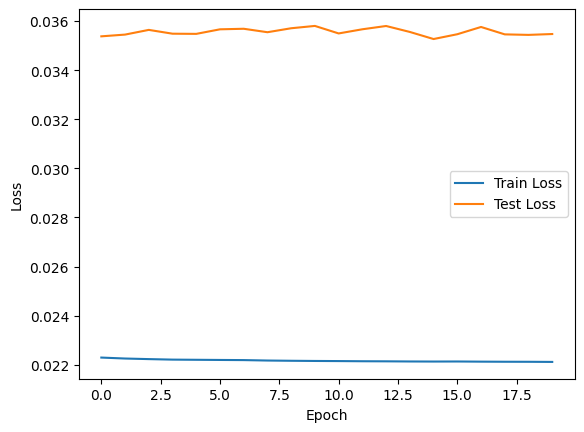

In [87]:
# now the same but with less epochs since the increase doesnt help to decrease the error anymore
n_lags=30
target_var = 'amortized_cost'

list_cols = []
for col in daily_df_new:
    col_df = time_delay_embedding(daily_df_new[col], n_lags=n_lags, horizon=180)
    list_cols.append(col_df)

# concatenating all variables and drop nulls
new_df = pd.concat(list_cols, axis=1).dropna()

# defining target (Y) and explanatory variables (X)
# explanatory variables now shouldnt include the target

predictor_variables = (new_df.columns.str.contains('\(t\-')) & (~new_df.columns.str.contains(target_var))
target_variables = new_df.columns.str.contains(f'{target_var}\(t\+')

X = new_df.iloc[:, predictor_variables]
Y = new_df.iloc[:, target_variables]

# split the same way into train test
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=0)

n_features = X_tr.shape[1]
X_tr_reshaped = X_tr.to_numpy().reshape(-1, 1, n_features)
X_ts_reshaped = X_ts.to_numpy().reshape(-1, 1, n_features)

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_tr_reshaped, Y_tr, epochs=20, batch_size=32, validation_data=(X_ts_reshaped, Y_ts))

# Train the model
history = model.fit(X_tr_reshaped, Y_tr, epochs=20, batch_size=32, validation_data=(X_ts_reshaped, Y_ts))

# Evaluate the model
train_loss = model.evaluate(X_tr_reshaped, Y_tr)
test_loss = model.evaluate(X_ts_reshaped, Y_ts)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# Make predictions
train_predictions = model.predict(X_tr_reshaped)
test_predictions = model.predict(X_ts_reshaped)

# Get the loss values from the history object
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Plot the loss values
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

As seen above, the model learned quite quickly its pattern and we don't gain much information/model improvement, when we iterate over more than **20 epochs**. The error seems relatively low already and slightly decreasing in the train and in the test as well, which is a good indicator.

However, they have quite some gap between them, which can mean that the model is slightly overfitted and, as we saw before, this is no surprise, as we still have highly correlated features and further PCA or feature reduction could have been done in order to avoid this.

Nevertheless, this model seems to be an improvement over the LGBM due to its MSE metric being lower for the test set (0.0221 vs 0.0492), even though we lose interpretability using this method.

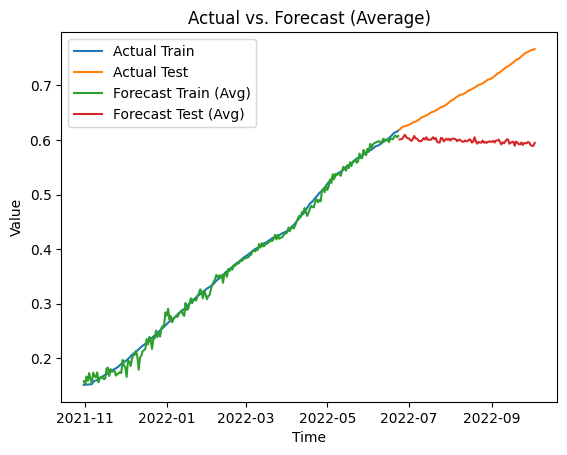

In [90]:
train_forecast_avg = np.mean(train_predictions, axis=1)
test_forecast_avg = np.mean(test_predictions, axis=1)

train_time_index = Y_tr.index
test_time_index = Y_ts.index

# Plot the actual values
plt.plot(train_time_index, np.mean(Y_tr, axis=1), label='Actual Train')
plt.plot(test_time_index, np.mean(Y_ts, axis=1), label='Actual Test')

# Plot the average forecasted values
plt.plot(train_time_index, train_forecast_avg, label='Forecast Train (Avg)')
plt.plot(test_time_index, test_forecast_avg, label='Forecast Test (Avg)')


plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Forecast (Average)')


plt.legend()
plt.show()

Finally, we'll see the most relevant features in the used models to complement the analysis.

Since this is a black box model with a lot of complex Neural Network relationships, then it's more difficult to do this analysis. A Shapley additive explanation method was tried to assess feature importance for this LSTM but without success, thus, **let's evaluate feature importance in the LGM model:**

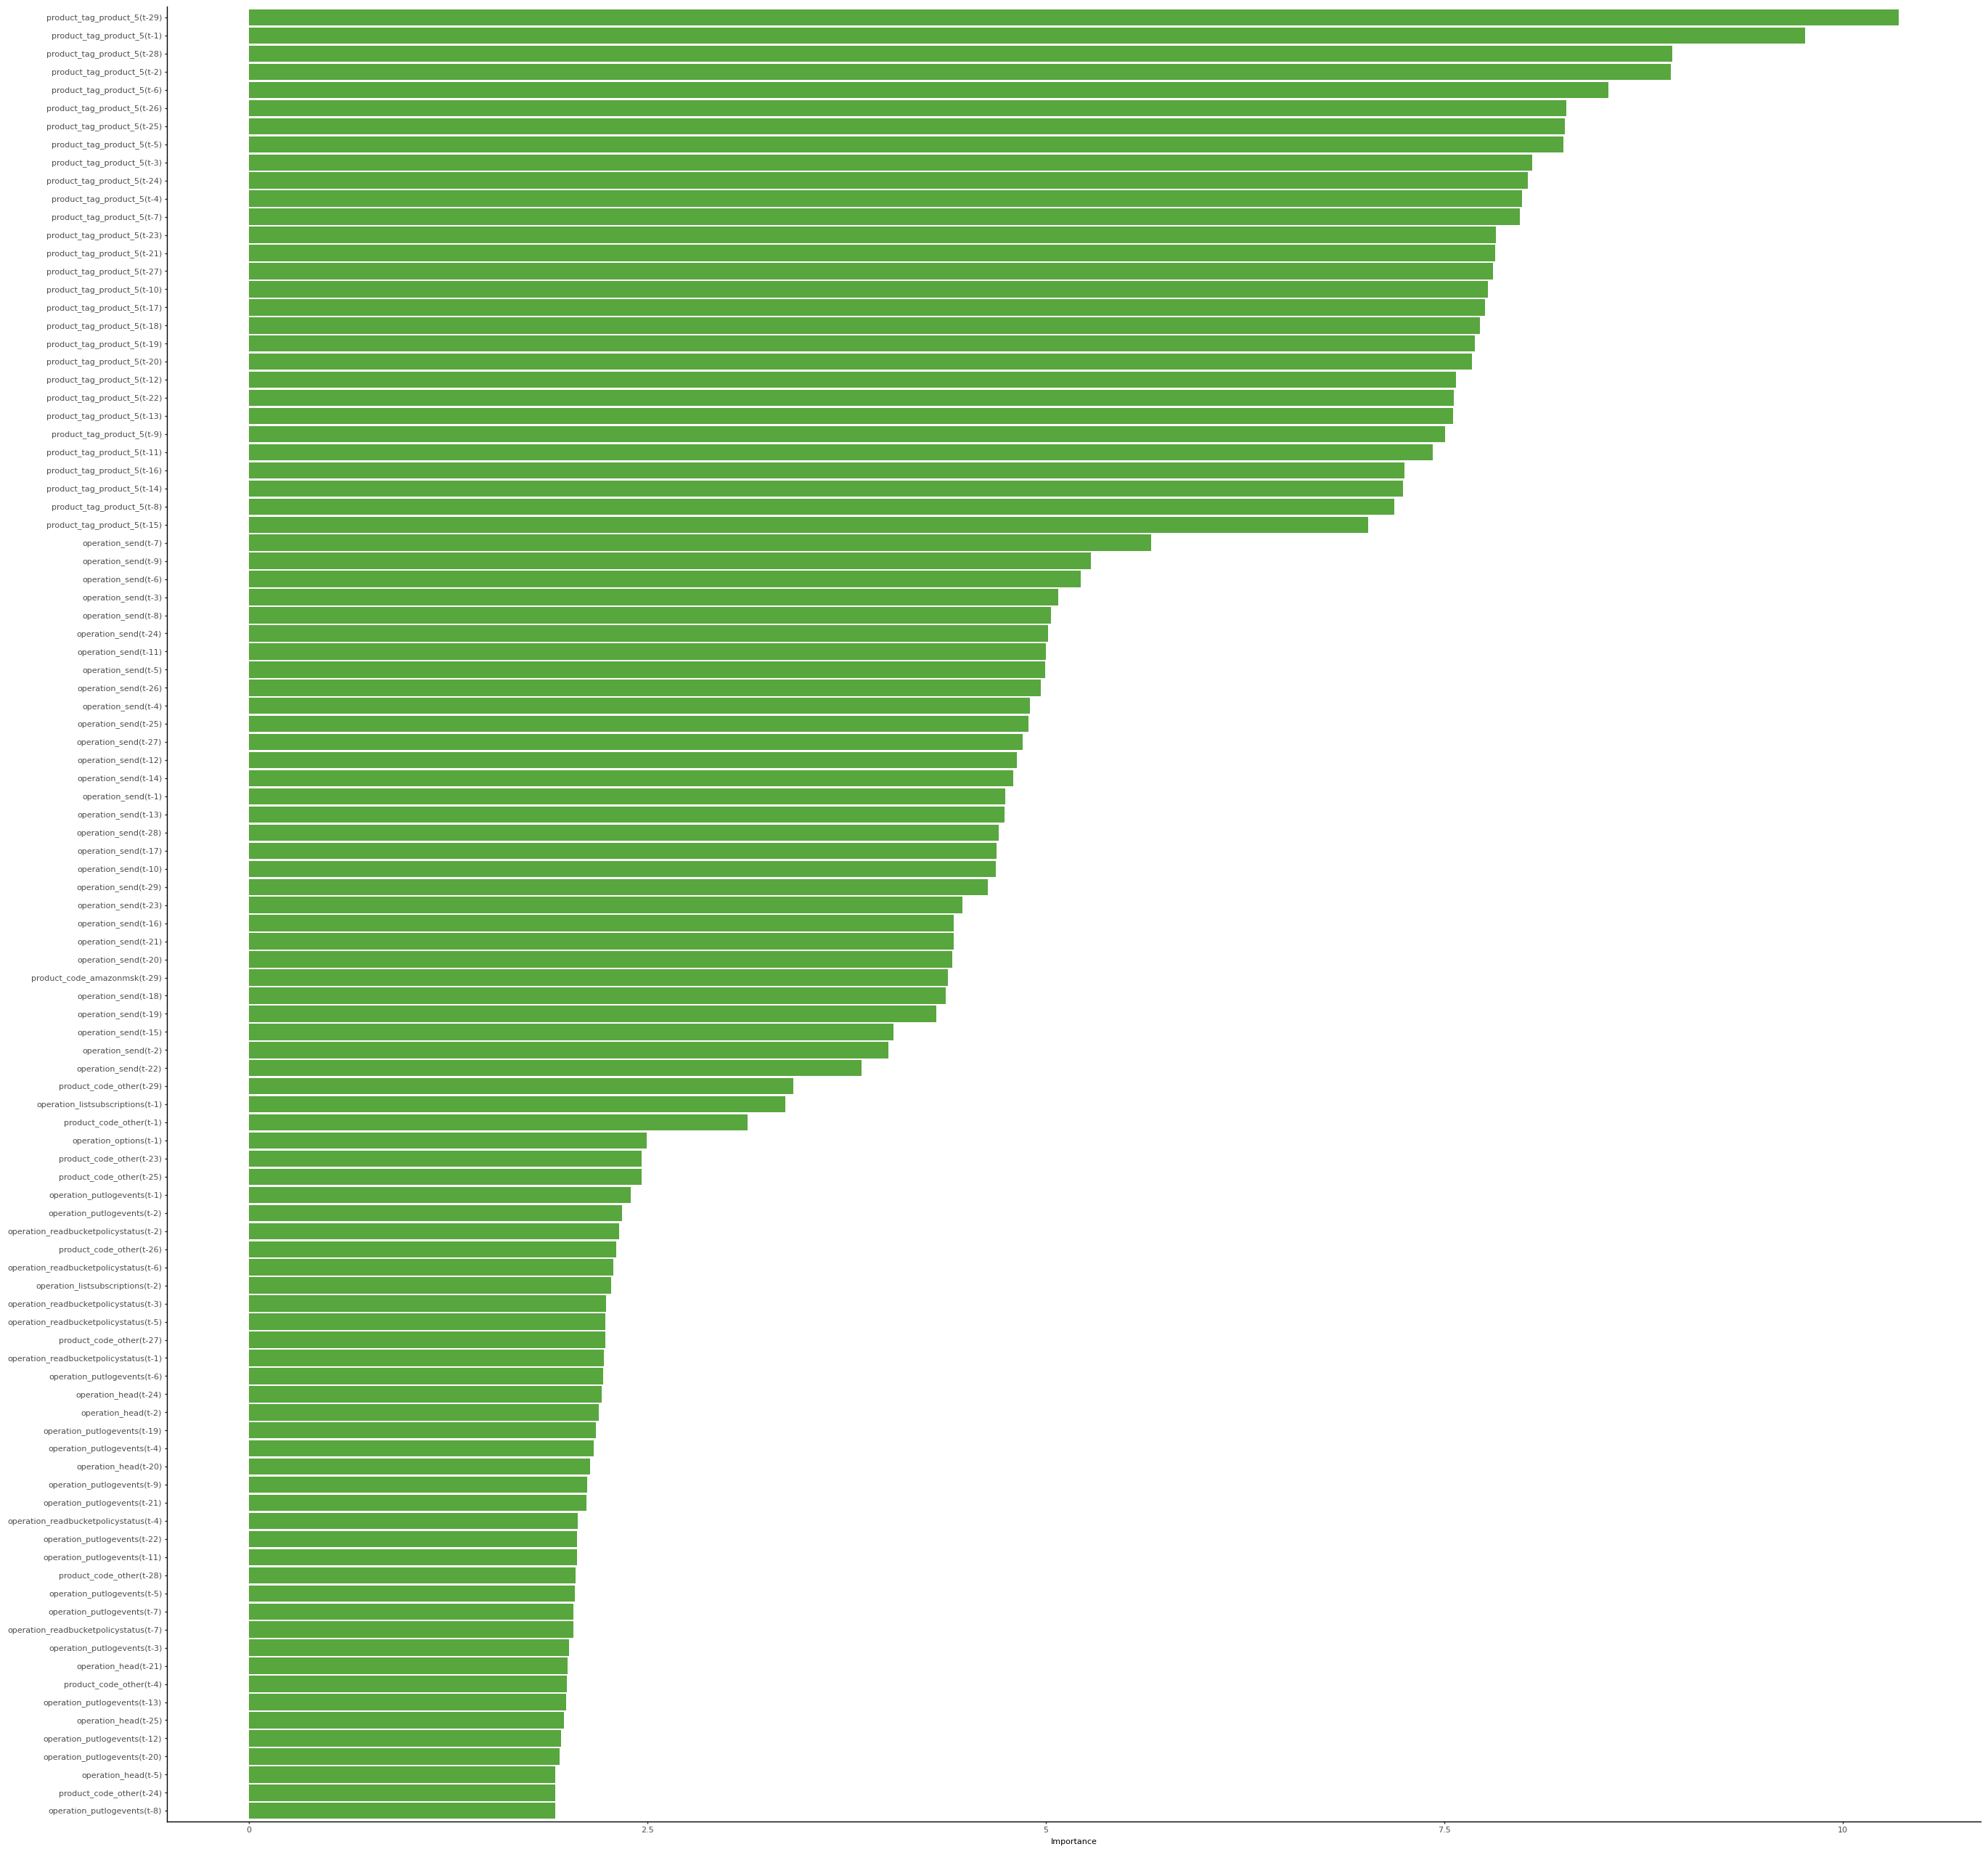

<ggplot: (8741490099369)>

In [91]:
# plot again feature importance for the LGBM model
plot = ggplot(imp_df, aes(x='Feature', y='Importance')) + \
       geom_bar(fill='#58a63e', stat='identity', position='dodge') + \
       theme_classic(
           base_size=10) + \
       theme(
           plot_margin=.25,
           axis_text=element_text(size=8),
           axis_text_x=element_text(size=8),
           axis_title=element_text(size=8),
           legend_text=element_text(size=8),
           legend_title=element_text(size=8),
           legend_position='top') + \
       xlab('') + \
       ylab('Importance') + coord_flip() + \
       theme(figure_size=(50, 50))

plot

As we can see, **The Product 5 labeled in Product Tag** is the most important feature (without accounting for the own cost feature and with different time lags. Moreover, **Send and List Subsriptions Operations** and **different Product Codes** (like Amazon MSK or "Others"), also contributte fairly well for our time series model.

**Note: Both of these models can be further exploited with hyperparameter fine tuning in order to have a better overall model and more adapted to this data. Further ML and DL models can be studeid and added as well.**

#Unsupervised Learning - Clustering

To answer to the second question of prioritization for optimization efforts (in terms of AWS service and/or infrastructure components), an unsupervised method was used, in order to group sets of data depending on the averages spend, in order to check for patterns in data.

For simplicity and good understandability, a **K-Means** algorithm was used in order to complement our data analysis and understand the main drivers of spend for the client.

##K-means Algoritm

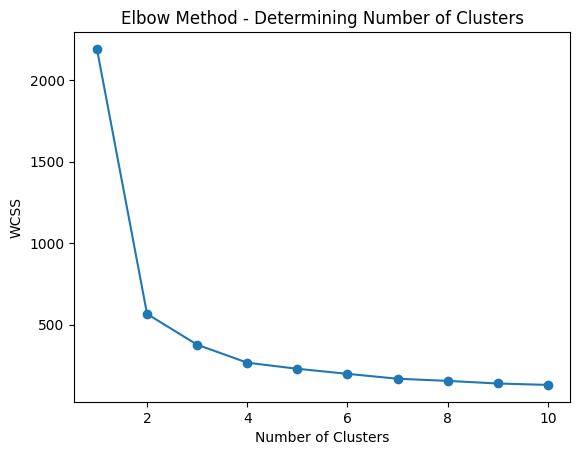

In [92]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans

df_cluster = daily_df_new.copy()

min_clusters = 1
max_clusters = 10

wcss = []

# Perform K-means clustering for different numbers of clusters
for n_clusters in range(min_clusters, max_clusters+1):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df_cluster)
    wcss.append(kmeans.inertia_)


plt.plot(range(min_clusters, max_clusters+1), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method - Determining Number of Clusters')
plt.show()

One good method to determine the optimal number of clusters is the **elbow method**, which is based on the sum of squared distance (SSE) between data points and their assigned clusters’ centroids. To find this number of clusters, we observe the elbow graphs and find more or less what is the position of the "elbow" formed by this line plot.


**In this case, the optimal seem to be 3 groups of clusters and that's what we are going to choose!**

In [93]:
X = daily_df_new.iloc[:,:-1]

# Define the number of clusters = 3
n_clusters = 3

# Initialize and fit the K-means clustering model
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

df_cluster['cluster'] = cluster_labels

for cluster in range(n_clusters):
    cluster_data = df_cluster[df_cluster['cluster'] == cluster]
    print(f"Cluster {cluster+1} - Size: {len(cluster_data)}")

Cluster 1 - Size: 216
Cluster 2 - Size: 253
Cluster 3 - Size: 78


In [94]:
cluster_summary = df_cluster.groupby('cluster')['amortized_cost'].mean()

print(cluster_summary)

cluster
0    0.154676
1    0.608369
2    0.739251
Name: amortized_cost, dtype: float64


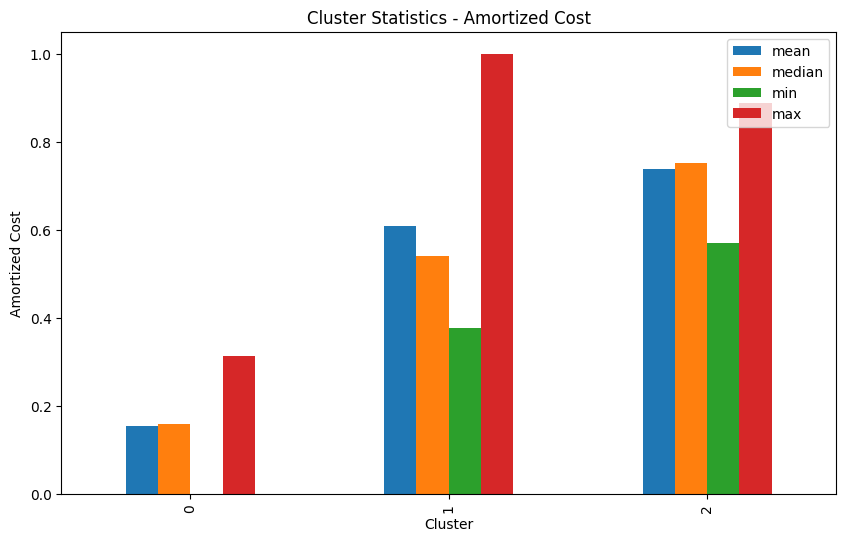

In [95]:
# Calculate aggregated statistics for the target variable based on each cluster
cluster_stats = df_cluster.groupby('cluster')['amortized_cost'].agg(['mean', 'median', 'min', 'max'])


cluster_stats.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Amortized Cost')
plt.title('Cluster Statistics - Amortized Cost')
plt.legend(loc='upper right')
plt.show()

In [96]:
df_cluster.to_excel('cluster.xlsx')

Here we can see well defined all 3 groups of data where we have **low average costs (Cluster 0), medium costs (cluster 1) and high average costs (Cluster 2)**. Let's see per variable, which one had the most importance.

In [97]:
# Calculate the average of each column within each cluster
cluster_averages = df_cluster.groupby('cluster').mean()

# Exclude the cluster and cost columns
columns = df_cluster.columns[:-2]

# Calculate the number of rows for the subplot grid
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(80, 100))

# Iterate over each column and plot the clusters
for i, column in enumerate(columns):
    # Calculate the subplot position
    row = int(i / n_cols)
    col = i % n_cols

    # Create the subplot
    ax = axes[row, col] if n_rows > 1 else axes[col]

    # Plot the average 'amortized_cost' per cluster and column
    sns.scatterplot(data=df_cluster, x=column, y='amortized_cost', hue='cluster', palette='viridis', ax=ax, alpha=0.5)
    sns.scatterplot(data=cluster_averages, x=column, y='amortized_cost', marker='X', color='red', ax=ax)

    ax.set_title(f'Average Cost per Cluster - {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Amortized Cost')
    ax.legend().remove()

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [98]:
# Now, filter only when cluster group = 0 (where we have the most average costs) and see top average of attributes
# Also, here is more visible the top important variables:

df_cluster_agg = df_cluster[df_cluster['cluster'] == 0].groupby('cluster').mean().T.sort_values(0, ascending=False)
df_cluster_agg

cluster,0
operation_clientvpnconnections,1.000000
operation_listdomains,0.986111
operation_listsubscriptions,0.787037
product_code_amazonvpc,0.668210
operation_createsnapshot,0.500000
product_tag_product_5,0.467756
operation_none,0.430556
operation_post,0.273148
operation_head,0.222685
operation_crossregion,0.217593


By the analysis of above graphs and the aggregate table, **we conclude that both client’s infrastructure components (product (tag) & environment (tag)) and the AWS service information** are key drivers for the increase in costs that's been happening.

On average, certain operations like "List Subscriptions", "create snapshots" and "VPN connections" are costly for the client. Other operations of course are included.

**In terms of infrustructure, we see products 4, 6 and 5 as the most relevant regrding the most costs increase and the UAT environment is often related with mosts costs as well. All of these are mostly related with the usage as well, because we know that the higher the usage in these products or services, the higher will be the costs. Thus, the client should focus on spending less resources in these fields and optimize both product and AWS service usage to control expenses.**

# Conclusions

**To sum up this exercise, we analysed and concluded that the client should:**


*   Focus on both AWS service and infrastructure usage amounts, to control better its costs.
*   Special focus on controlling Operations such as Listing Subscriptions, Creating Snapshots of data and providing VPN acesses


*   Regarding the Product and environment side: Products 4,6,5 and UAT working env should be prioritized as these are usually associated with high costs per usage or high usages



*   In terms of forecasting costs, we discovered that the main drivers on the product side is clearly the Product 5 (with different time lags), but also other Product Codes and "Send" Operations are big drivers when we want to forecast future costs based on the past data we have available.

# References


*   https://www.activestate.com/blog/top-10-tools-for-hyperparameter-optimization-in-python/

*   https://dataconomy.com/2022/11/25/time-series-forecasting-machine-learning/


*   https://machinelearningmastery.com/clustering-algorithms-with-python/

*   https://github.com/austinnottexas/ConvolutionalCloudWorkloadAnalysis

*   https://docs.aws.amazon.com/cur/latest/userguide/data-dictionary.html

*   https://towardsdatascience.com/11-dimensionality-reduction-techniques-you-should-know-in-2021-dcb9500d388b
*   https://machinelearningmastery.com/data-leakage-machine-learning/


*   https://aws.amazon.com/pt/route53/faqs/


*   https://www.kaggle.com/code/vprokopev/mean-likelihood-encodings-a-comprehensive-study/notebook


*   https://blog.paperspace.com/time-series-forecasting-regression-and-lstm/

*   https://blog.paperspace.com/time-series-forecasting-autoregressive-models-smoothing-methods/

*   https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/

*   https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html





















